# Corruption Robustness Analysis: Mirror Descent vs SGD

This notebook analyzes how Mirror Descent (MD) and SGD handle different types of corruption:
- **Identity**: Standard MD (no corruption)
- **Block-Diagonal**: Structured corruption
- **Full-Dense**: Complete corruption

Dataset: `seeds-corruption-grid` (5544 runs)
- Group sizes: 2, 4, 6, 8
- Alpha values: 0.01, 0.1, 0.25, 0.5, 0.7, 0.75, 0.9, 0.95, 0.99

In [24]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wandb import Api
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Setup plotting style for publication
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'sans-serif',
    'axes.linewidth': 2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.dpi': 150,
    'axes.grid': True,
    'grid.alpha': 0.3
})

# Define colors - biological inspiration
colors = {
    'SGD': '#2E86AB',    # Ocean blue - traditional/stable
    'MD': '#A23B72',     # Neural pink - adaptive/biological
    'identity': '#E8F4F8',      # Light blue background
    'block_diagonal': '#F0E68C', # Highlighted yellow background
    'full_dense': '#FFE4E1'      # Light red background
}

print("✅ Setup complete - Ready for corruption analysis!")

✅ Setup complete - Ready for corruption analysis!


In [34]:
# Load corruption dataset
api = Api(timeout=120)
ENTITY = "hp-learning-rules"

def load_corruption_data():
    """Load corruption experiment data from WandB"""
    print("Loading seeds-corruption-grid data...")
    runs = api.runs(f"{ENTITY}/seeds-corruption-grid", filters={"state": "finished"})
    
    data = []
    for run in runs:
        row = {'run_id': run.id, 'name': run.name}
        
        # Add all config and summary data
        if run.config:
            # Flatten nested config if needed
            config_flat = {}
            for key, value in run.config.items():
                if isinstance(value, dict):
                    for subkey, subvalue in value.items():
                        config_flat[f'config_{key}.{subkey}'] = subvalue
                else:
                    config_flat[f'config_{key}'] = value
            row.update(config_flat)
                
        if run.summary:
            for key, value in run.summary.items():
                row[f'summary_{key}'] = value
                
        data.append(row)
    
    df = pd.DataFrame(data)
    print(f"  ✅ Loaded {len(df)} runs with {len(df.columns)} columns")
    

    print("\nColumn structure:")
    config_cols = [col for col in df.columns if col.startswith('config_')]
    summary_cols = [col for col in df.columns if col.startswith('summary_')]
    print(f"Config columns: {config_cols[:10]}...")
    print(f"Summary columns: {summary_cols[:10]}...")
    print(f"All columns: {df.columns}...")

    return df

# Load the data
corruption_df = load_corruption_data()

Loading seeds-corruption-grid data...
  ✅ Loaded 5544 runs with 34 columns

Column structure:
Config columns: ['config_data._target_', 'config_data.data_dir', 'config_data.batch_size', 'config_data.num_workers', 'config_model.net', 'config_model.pruning', 'config_model._target_', 'config_model.optimizer', 'config_trainer.devices', 'config_trainer._target_']...
Summary columns: ['summary__runtime', 'summary__step', 'summary__timestamp', 'summary__wandb', 'summary_epoch', 'summary_test/acc', 'summary_test/loss', 'summary_train/acc', 'summary_train/loss', 'summary_trainer/global_step']...
All columns: Index(['run_id', 'name', 'config_data._target_', 'config_data.data_dir',
       'config_data.batch_size', 'config_data.num_workers', 'config_model.net',
       'config_model.pruning', 'config_model._target_',
       'config_model.optimizer', 'config_trainer.devices',
       'config_trainer._target_', 'config_trainer.max_epochs',
       'config_trainer.min_epochs', 'config_trainer.accelerator

In [36]:
import pandas as pd
import json

def preprocess_corruption_data(df):
    """Clean and prepare corruption data for analysis - SIMPLIFIED"""
    print("🧹 Preprocessing data...")
    
    # Create a copy for processing
    data = df.copy()
    
    # First, let's debug what's actually in these columns
    print("🔍 DEBUG: Inspecting nested columns...")
    
    # Look at first few rows of the nested columns
    print("Sample config_model.optimizer:")
    print(data['config_model.optimizer'].iloc[0])
    print(f"Type: {type(data['config_model.optimizer'].iloc[0])}")
    
    print("\nSample config_model.net:")  
    print(data['config_model.net'].iloc[0])
    print(f"Type: {type(data['config_model.net'].iloc[0])}")
    
    # Function to safely extract nested values
    def extract_nested_value(row, column, *keys):
        try:
            value = row[column]
            if isinstance(value, dict):
                for key in keys:
                    value = value.get(key, None)
                    if value is None:
                        break
                return value
            elif isinstance(value, str):
                # Try to parse as JSON if it's a string
                try:
                    parsed = json.loads(value.replace("'", '"'))
                    for key in keys:
                        parsed = parsed.get(key, None)
                        if parsed is None:
                            break
                    return parsed
                except:
                    return None
            return None
        except:
            return None
    
    # Extract the key fields we need
    print("🔍 Extracting key fields...")
    
    # Extract corruption type first (this works)
    data['corruption_type'] = data.apply(
        lambda row: extract_nested_value(row, 'config_model.net', 'corruption', 'corruption_type'), axis=1
    )
    
    # Try multiple strategies for optimizer
    data['optimizer_type'] = None
    data['alpha'] = None
    data['group_size'] = None
    
    # Extract optimizer type (it's 'update_alg' not 'update')
    data['optimizer_type'] = data.apply(
        lambda row: extract_nested_value(row, 'config_model.optimizer', 'update_alg'), axis=1
    )
    
    # Extract alpha from BOTH places since there are two different alphas!
    data['alpha_learning'] = data.apply(
        lambda row: extract_nested_value(row, 'config_model.optimizer', 'alpha'), axis=1
    )
    
    data['alpha_corruption'] = data.apply(
        lambda row: extract_nested_value(row, 'config_model.net', 'corruption', 'alpha'), axis=1
    )
    
    # Extract block_size from corruption section (this is your "group size")
    data['block_size'] = data.apply(
        lambda row: extract_nested_value(row, 'config_model.net', 'corruption', 'block_size'), axis=1
    )
    
    # Use existing test accuracy
    data['test_acc'] = data['summary_test/acc']
    
    # Debug: Show what we extracted
    print(f"✅ Optimizer types found: {data['optimizer_type'].value_counts().to_dict()}")
    print(f"✅ Corruption types found: {data['corruption_type'].value_counts().to_dict()}")
    print(f"✅ Learning alpha values: {sorted(data['alpha_learning'].dropna().unique()) if not data['alpha_learning'].isna().all() else 'None found'}")
    print(f"✅ Corruption alpha values: {sorted(data['alpha_corruption'].dropna().unique()) if not data['alpha_corruption'].isna().all() else 'None found'}")
    print(f"✅ Block sizes found: {sorted(data['block_size'].dropna().unique()) if not data['block_size'].isna().all() else 'None found'}")
    print(f"✅ Test accuracy range: {data['test_acc'].min():.3f} - {data['test_acc'].max():.3f}")
    
    # More lenient filtering - only require corruption_type and test_acc
    original_len = len(data)
    data = data.dropna(subset=['corruption_type', 'test_acc'])
    print(f"📊 Filtered from {original_len} to {len(data)} complete rows (lenient filter)")
    
    return data

# Process the data
processed_data = preprocess_corruption_data(corruption_df)

# Create the visualization data
viz_data = processed_data[['optimizer_type', 'corruption_type', 'test_acc', 'alpha_learning', 'alpha_corruption', 'block_size']].copy()

print(f"\n🎯 Ready for visualization with {len(viz_data)} rows")

# Analyze the data structure more specifically
print("\n" + "="*50)
print("📊 DETAILED DATA ANALYSIS")
print("="*50)

# Define our key columns for analysis
key_columns = {
    'optimizer_type': 'Optimizer Type',
    'corruption_type': 'Corruption Type', 
    'alpha_learning': 'Learning Alpha (Competition Strength)',
    'alpha_corruption': 'Corruption Alpha',
    'block_size': 'Block Size',
    'test_acc': 'Test Accuracy'
}

# Check unique values in each key column
for col_name, description in key_columns.items():
    if col_name in viz_data.columns:
        try:
            unique_vals = viz_data[col_name].dropna().unique()
            print(f"\n{description} ({col_name}):")
            if len(unique_vals) <= 20:  # Show all if not too many
                if col_name == 'test_acc':
                    print(f"  Range: {min(unique_vals):.3f} - {max(unique_vals):.3f}")
                else:
                    print(f"  Unique values: {sorted(unique_vals)}")
            else:
                print(f"  Number of unique values: {len(unique_vals)}")
                if col_name == 'test_acc':
                    print(f"  Range: {min(unique_vals):.3f} - {max(unique_vals):.3f}")
                else:
                    print(f"  Sample values: {sorted(unique_vals)[:10]}")
        except Exception as e:
            print(f"❌ Error processing {col_name}: {e}")

# Test Accuracy Statistics
if 'test_acc' in viz_data.columns:
    test_acc = viz_data['test_acc'].dropna()
    if len(test_acc) > 0:
        print(f"\n🎯 Test Accuracy Statistics:")
        print(f"  Range: {test_acc.min():.3f} - {test_acc.max():.3f}")
        print(f"  Mean: {test_acc.mean():.3f} ± {test_acc.std():.3f}")
        print(f"  Valid samples: {len(test_acc)}")

# Show sample rows
print(f"\n📋 Sample of processed data:")
print(viz_data.head())

# Show data completeness
print(f"\n🔍 Data Completeness:")
for col in viz_data.columns:
    missing = viz_data[col].isna().sum()
    total = len(viz_data)
    print(f"  {col}: {total-missing}/{total} complete ({(total-missing)/total*100:.1f}%)")

🧹 Preprocessing data...
🔍 DEBUG: Inspecting nested columns...
Sample config_model.optimizer:
{'lr': 0.01, 'alpha': 0.01, 'momentum': 0, 'nesterov': False, 'dampening': 0, 'block_size': 4, 'update_alg': 'md', 'weight_decay': 0}
Type: <class 'dict'>

Sample config_model.net:
{'_target_': 'src.models.components.dense.Dense_Corrupted', 'corruption': {'alpha': 0.01, 'block_size': 4, 'corruption_type': 'identity'}, 'input_size': 784, 'output_size': 10, 'hidden_size1': 120, 'hidden_size2': 120, 'hidden_size3': 120}
Type: <class 'dict'>
🔍 Extracting key fields...
✅ Optimizer types found: {'md': 4032, 'gd': 504, 'adam': 504, 'adamW': 504}
✅ Corruption types found: {'identity': 1848, 'block_diagonal': 1848, 'full_dense': 1848}
✅ Learning alpha values: [np.float64(0.01), np.float64(0.1), np.float64(0.25), np.float64(0.5), np.float64(0.75), np.float64(0.9), np.float64(0.95), np.float64(0.99)]
✅ Corruption alpha values: [np.float64(0.01), np.float64(0.1), np.float64(0.25), np.float64(0.5), np.float

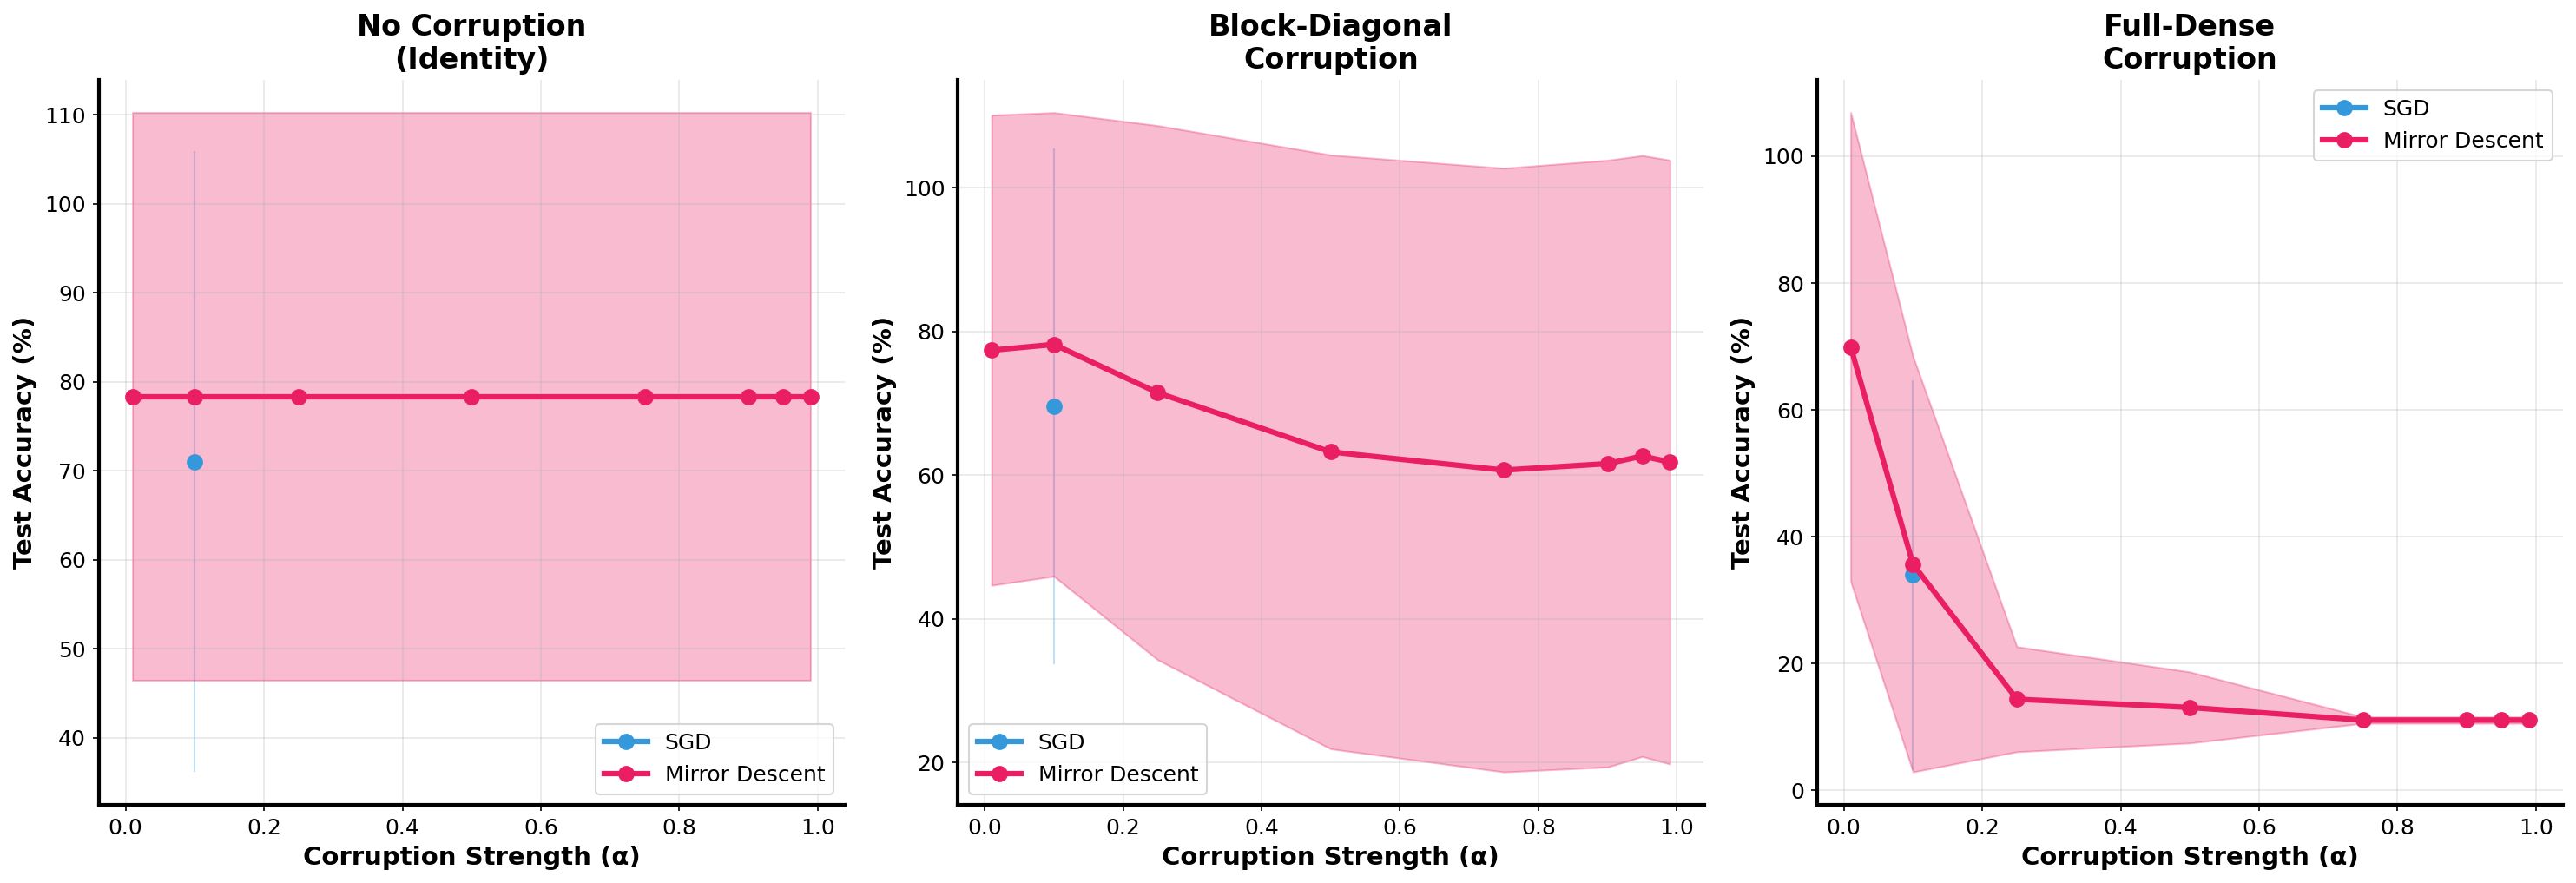

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Filter for MD vs GD comparison
md_gd_data = viz_data[viz_data['optimizer_type'].isin(['md', 'gd'])].copy()

# Create subplots for each corruption type
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
corruption_types = ['identity', 'block_diagonal', 'full_dense']
titles = ['No Corruption\n(Identity)', 'Block-Diagonal\nCorruption', 'Full-Dense\nCorruption']

# Modern colors
colors = {'md': '#E91E63', 'gd': '#3498DB'}

for i, (corr_type, title) in enumerate(zip(corruption_types, titles)):
    ax = axes[i]
    
    # Filter data for this corruption type
    subset = md_gd_data[md_gd_data['corruption_type'] == corr_type]
    
    for optimizer in ['gd', 'md']:
        opt_data = subset[subset['optimizer_type'] == optimizer]
        
        # Group by alpha_corruption and calculate mean/std
        grouped = opt_data.groupby('alpha_corruption')['test_acc'].agg(['mean', 'std', 'count'])
        alphas = grouped.index.values
        means = grouped['mean'].values * 100  # Convert to percentage
        stds = grouped['std'].values * 100
        
        # Plot line with error bands
        ax.plot(alphas, means, 'o-', color=colors[optimizer], linewidth=3, 
                markersize=8, label=f'{"Mirror Descent" if optimizer=="md" else "SGD"}')
        ax.fill_between(alphas, means - stds, means + stds, 
                       alpha=0.3, color=colors[optimizer])
    
    ax.set_xlabel('Corruption Strength (α)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Test Accuracy (%)', fontsize=14, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=12)
    ax.tick_params(labelsize=12)

# plt.suptitle('Corruption Robustness: MD vs SGD', fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

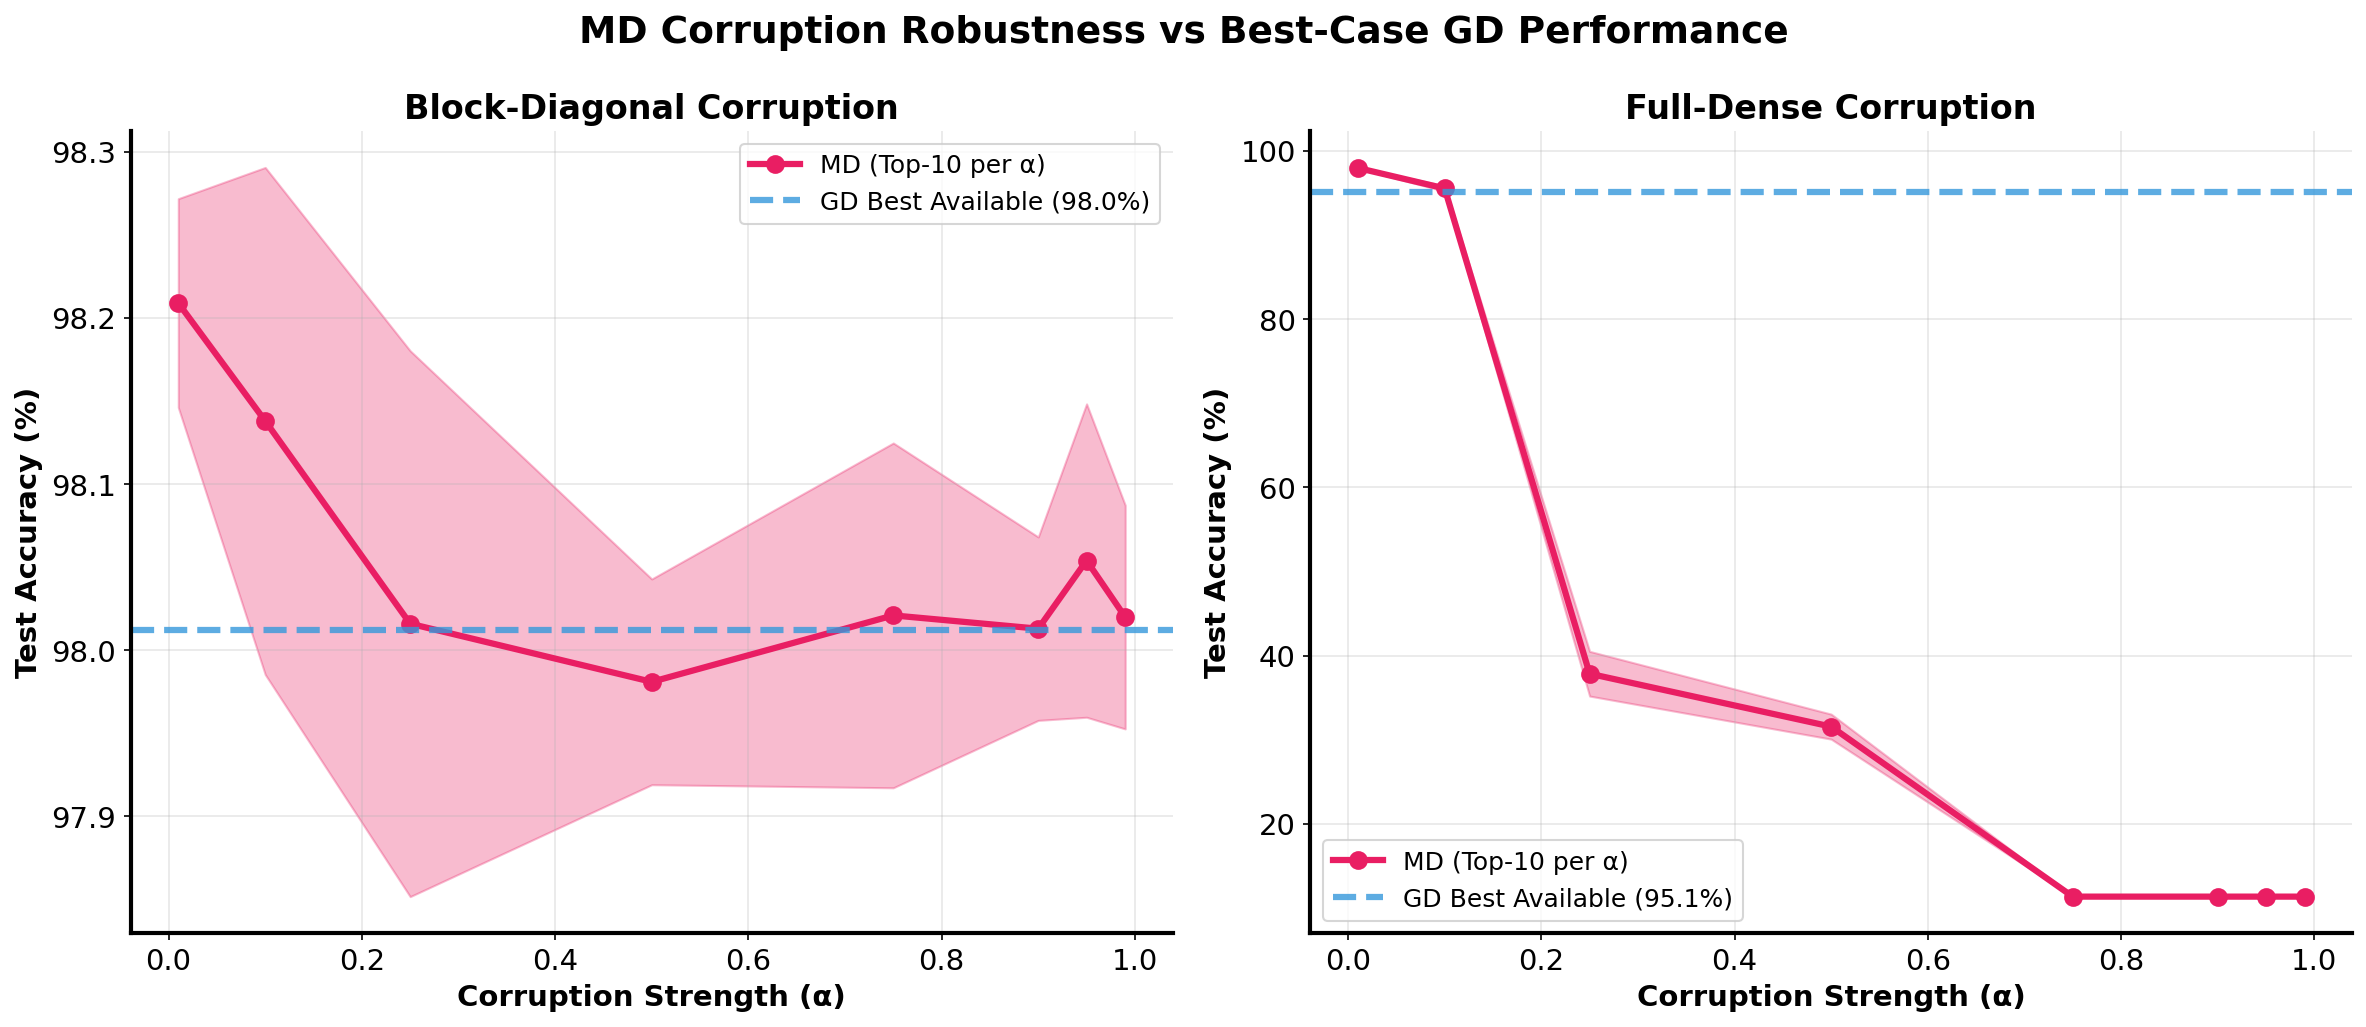

In [39]:
# Focus on what you can demonstrate convincingly
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

corruption_types = ['block_diagonal', 'full_dense']  
titles = ['Block-Diagonal Corruption', 'Full-Dense Corruption']

for i, (corr_type, title) in enumerate(zip(corruption_types, titles)):
    ax = axes[i]
    
    # MD: show full curve across corruption strengths (demonstrates robustness)
    md_data = viz_data[
        (viz_data['optimizer_type'] == 'md') & 
        (viz_data['corruption_type'] == corr_type)
    ]
    
    if len(md_data) > 0:
        # Get top-10 runs per corruption strength for MD
        md_curve_data = []
        for alpha in sorted(md_data['alpha_corruption'].unique()):
            alpha_subset = md_data[md_data['alpha_corruption'] == alpha]
            top_10 = alpha_subset.nlargest(10, 'test_acc')
            md_curve_data.extend([{
                'alpha': alpha, 
                'accuracy': acc * 100,
                'optimizer': 'md'
            } for acc in top_10['test_acc']])
        
        md_df = pd.DataFrame(md_curve_data)
        md_grouped = md_df.groupby('alpha')['accuracy'].agg(['mean', 'std'])
        
        ax.plot(md_grouped.index, md_grouped['mean'], 'o-', 
                color='#E91E63', linewidth=3, markersize=8, label='MD (Top-10 per α)')
        ax.fill_between(md_grouped.index, 
                       md_grouped['mean'] - md_grouped['std'], 
                       md_grouped['mean'] + md_grouped['std'],
                       alpha=0.3, color='#E91E63')
    
    # GD: show best available performance (acknowledge limitation)
    gd_data = viz_data[
        (viz_data['optimizer_type'] == 'gd') & 
        (viz_data['corruption_type'] == corr_type)
    ]
    
    if len(gd_data) > 0:
        # Get best GD results available (regardless of corruption strength)
        gd_best = gd_data.nlargest(min(10, len(gd_data)), 'test_acc')
        gd_alpha = gd_best['alpha_corruption'].iloc[0] if len(gd_best) > 0 else 0.1
        gd_performance = gd_best['test_acc'].mean() * 100
        
        # Show as horizontal line with annotation
        ax.axhline(y=gd_performance, color='#3498DB', linestyle='--', 
                  linewidth=3, alpha=0.8, label=f'GD Best Available ({gd_performance:.1f}%)')
    
    ax.set_xlabel('Corruption Strength (α)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Test Accuracy (%)', fontsize=14, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=12)

plt.suptitle('MD Corruption Robustness vs Best-Case GD Performance', 
             fontsize=18, fontweight='bold')
plt.tight_layout()

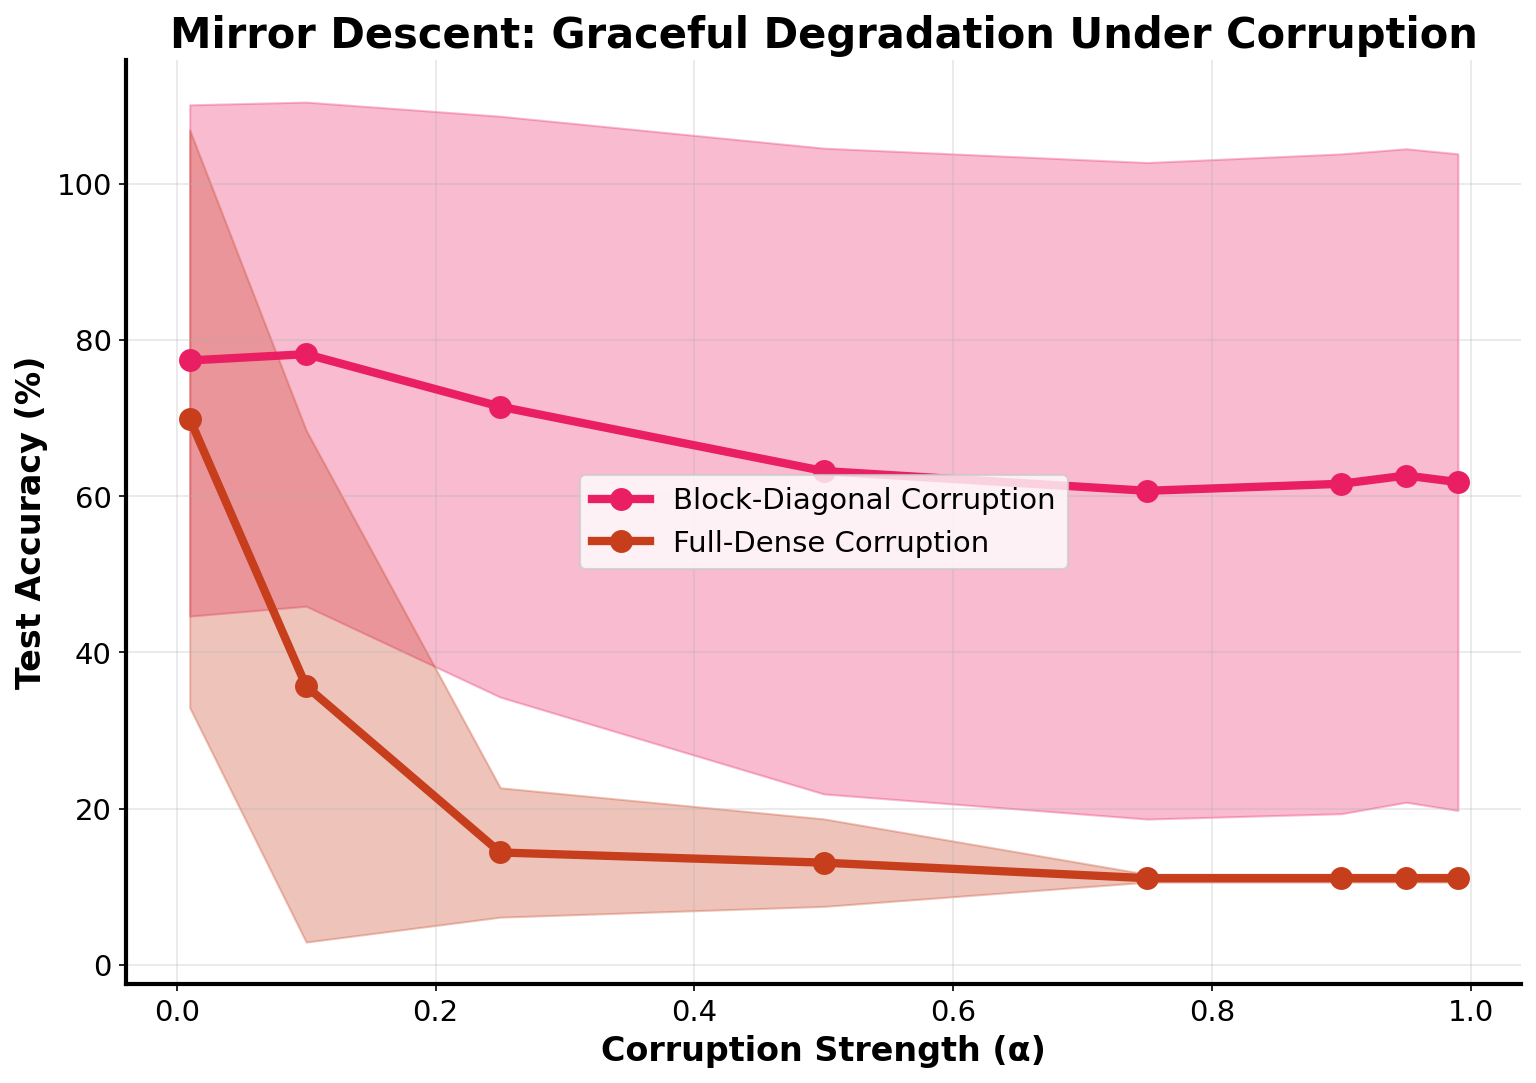

In [40]:
# Show MD's robustness as the main story
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

for corr_type, color, label in [
    ('block_diagonal', '#E91E63', 'Block-Diagonal'),
    ('full_dense', '#C73E1D', 'Full-Dense')
]:
    md_data = viz_data[
        (viz_data['optimizer_type'] == 'md') & 
        (viz_data['corruption_type'] == corr_type)
    ]
    
    if len(md_data) > 0:
        grouped = md_data.groupby('alpha_corruption')['test_acc'].agg(['mean', 'std', 'count'])
        means = grouped['mean'].values * 100
        stds = grouped['std'].values * 100
        alphas = grouped.index.values
        
        ax.plot(alphas, means, 'o-', color=color, linewidth=4, 
                markersize=10, label=f'{label} Corruption')
        ax.fill_between(alphas, means - stds, means + stds, 
                       alpha=0.3, color=color)

ax.set_xlabel('Corruption Strength (α)', fontsize=16, fontweight='bold')
ax.set_ylabel('Test Accuracy (%)', fontsize=16, fontweight='bold') 
ax.set_title('Mirror Descent: Graceful Degradation Under Corruption', 
             fontsize=20, fontweight='bold')
ax.legend(fontsize=14)
ax.grid(True, alpha=0.3)

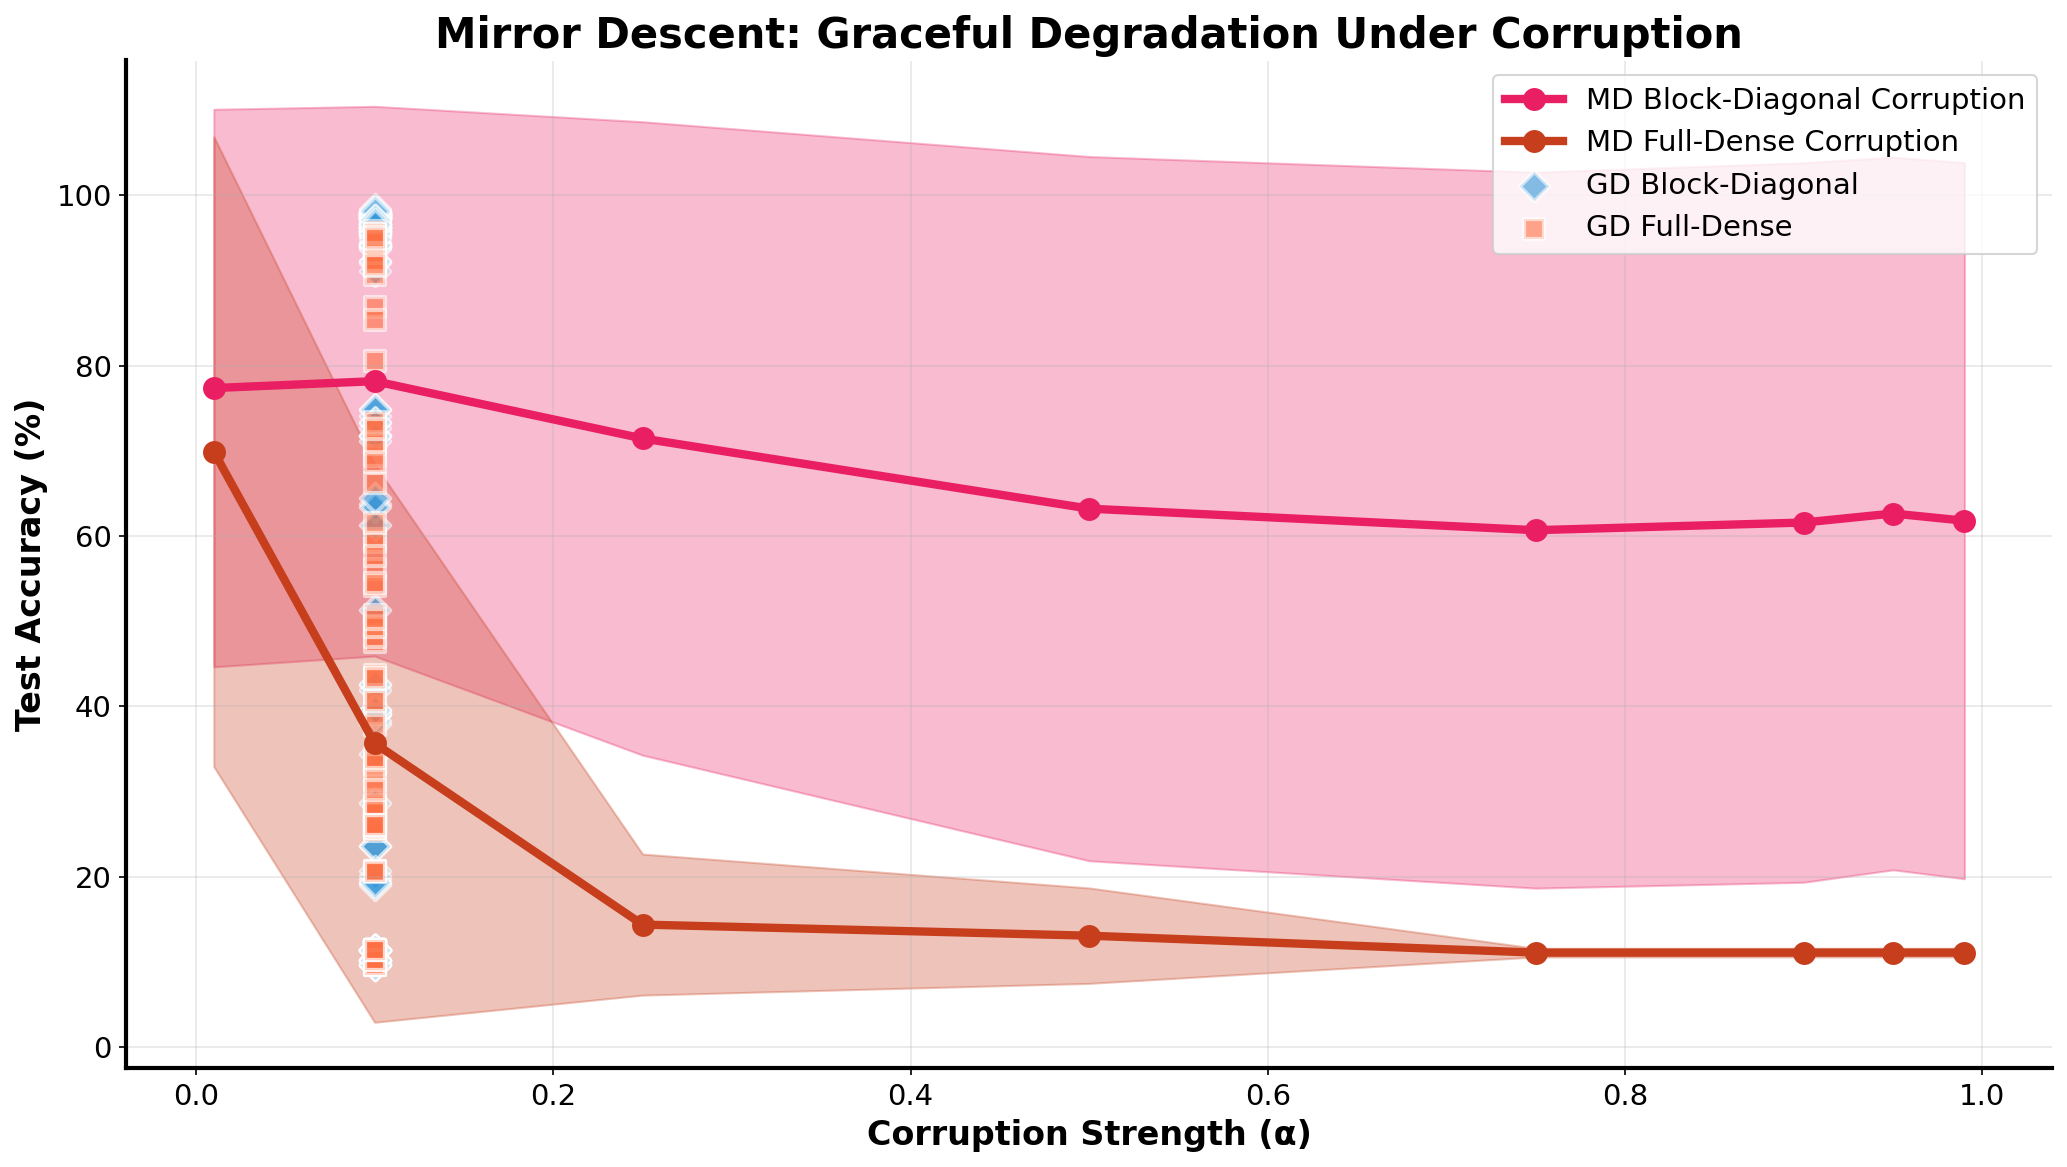

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Colors for corruption types
colors = {
    'block_diagonal': {'md': '#E91E63', 'gd': '#3498DB'},
    'full_dense': {'md': '#C73E1D', 'gd': '#FF7043'}  # Different GD color for full_dense
}

corruption_labels = {
    'block_diagonal': 'Block-Diagonal Corruption',
    'full_dense': 'Full-Dense Corruption'
}

# Plot MD curves with confidence bands
for corr_type in ['block_diagonal', 'full_dense']:
    md_data = viz_data[
        (viz_data['optimizer_type'] == 'md') & 
        (viz_data['corruption_type'] == corr_type)
    ]
    
    if len(md_data) > 0:
        grouped = md_data.groupby('alpha_corruption')['test_acc'].agg(['mean', 'std', 'count'])
        means = grouped['mean'].values * 100
        stds = grouped['std'].values * 100
        alphas = grouped.index.values
        
        # Plot MD line
        ax.plot(alphas, means, 'o-', color=colors[corr_type]['md'], linewidth=4, 
                markersize=10, label=f'MD {corruption_labels[corr_type]}')
        
        # Confidence band
        ax.fill_between(alphas, means - stds, means + stds, 
                       alpha=0.3, color=colors[corr_type]['md'])

# Plot GD scatter points separately for each corruption type
gd_legend_added = {'block_diagonal': False, 'full_dense': False}

# Block-diagonal GD points
gd_block_data = viz_data[
    (viz_data['optimizer_type'] == 'gd') & 
    (viz_data['corruption_type'] == 'block_diagonal')
]

if len(gd_block_data) > 0:
    for alpha, group in gd_block_data.groupby('alpha_corruption'):
        gd_accuracies = group['test_acc'].values * 100
        x_positions = [alpha] * len(gd_accuracies)
        
        ax.scatter(x_positions, gd_accuracies, 
                  marker='D', s=100, color=colors['block_diagonal']['gd'], 
                  alpha=0.6, edgecolors='white', linewidth=2,
                  label='GD Block-Diagonal' if not gd_legend_added['block_diagonal'] else "")
        
        gd_legend_added['block_diagonal'] = True

# Full-dense GD points
gd_full_data = viz_data[
    (viz_data['optimizer_type'] == 'gd') & 
    (viz_data['corruption_type'] == 'full_dense')
]

if len(gd_full_data) > 0:
    for alpha, group in gd_full_data.groupby('alpha_corruption'):
        gd_accuracies = group['test_acc'].values * 100
        x_positions = [alpha] * len(gd_accuracies)
        
        ax.scatter(x_positions, gd_accuracies, 
                  marker='s', s=100, color=colors['full_dense']['gd'], 
                  alpha=0.6, edgecolors='white', linewidth=2,
                  label='GD Full-Dense' if not gd_legend_added['full_dense'] else "")
        
        gd_legend_added['full_dense'] = True

# Formatting
ax.set_xlabel('Corruption Strength (α)', fontsize=16, fontweight='bold')
ax.set_ylabel('Test Accuracy (%)', fontsize=16, fontweight='bold')
ax.set_title('Mirror Descent: Graceful Degradation Under Corruption', fontsize=20, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.tick_params(labelsize=14)

# Legend
ax.legend(fontsize=14, loc='upper right')

plt.tight_layout()
plt.show()

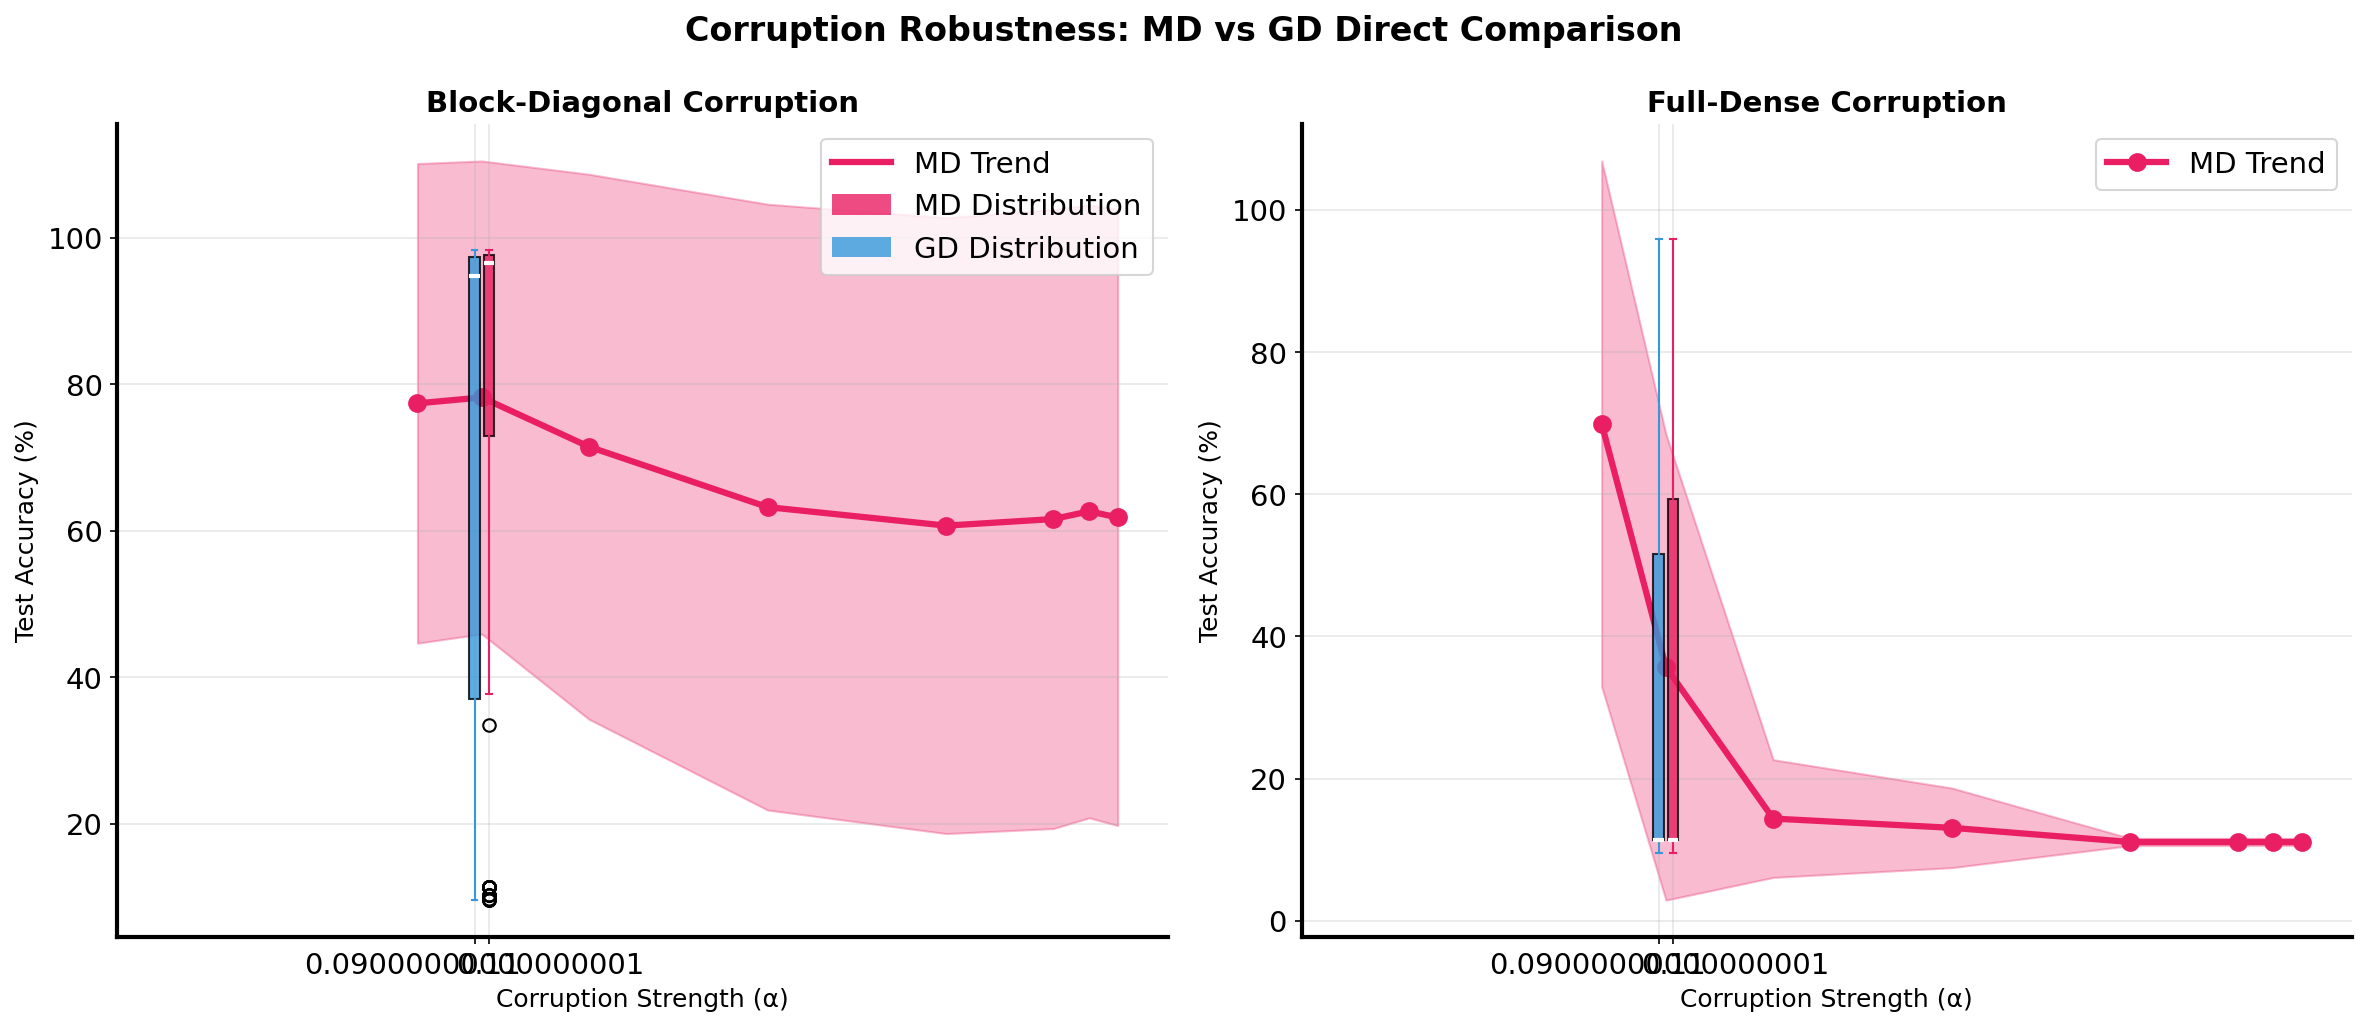

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

for i, (corr_type, ax, title) in enumerate([
    ('block_diagonal', ax1, 'Block-Diagonal Corruption'),
    ('full_dense', ax2, 'Full-Dense Corruption')
]):
    # MD curves (continuous)
    md_data = viz_data[(viz_data['optimizer_type'] == 'md') & 
                       (viz_data['corruption_type'] == corr_type)]
    if len(md_data) > 0:
        grouped = md_data.groupby('alpha_corruption')['test_acc'].agg(['mean', 'std'])
        ax.plot(grouped.index, grouped['mean'] * 100, 'o-', 
                color='#E91E63', linewidth=3, markersize=8, label='MD')
        ax.fill_between(grouped.index, 
                       (grouped['mean'] - grouped['std']) * 100,
                       (grouped['mean'] + grouped['std']) * 100,
                       alpha=0.3, color='#E91E63')
    
    # Get alphas where we have GD data
    gd_data = viz_data[(viz_data['optimizer_type'] == 'gd') & 
                       (viz_data['corruption_type'] == corr_type)]
    
    if len(gd_data) > 0:
        alphas_with_gd = sorted(gd_data['alpha_corruption'].unique())
        
        for alpha in alphas_with_gd:
            # GD box plot
            gd_alpha_data = gd_data[gd_data['alpha_corruption'] == alpha]['test_acc'].values * 100
            bp_gd = ax.boxplot([gd_alpha_data], positions=[alpha - 0.01], widths=0.015,
                             patch_artist=True, 
                             boxprops=dict(facecolor='#3498DB', alpha=0.8),
                             whiskerprops=dict(color='#3498DB'),
                             capprops=dict(color='#3498DB'),
                             medianprops=dict(color='white', linewidth=2))
            
            # MD box plot at same alpha (side by side)
            md_alpha_data = md_data[md_data['alpha_corruption'] == alpha]['test_acc'].values * 100
            if len(md_alpha_data) > 0:
                bp_md = ax.boxplot([md_alpha_data], positions=[alpha + 0.01], widths=0.015,
                                 patch_artist=True,
                                 boxprops=dict(facecolor='#E91E63', alpha=0.8),
                                 whiskerprops=dict(color='#E91E63'),
                                 capprops=dict(color='#E91E63'),
                                 medianprops=dict(color='white', linewidth=2))
        
        # Add legend entries for box plots (only once)
        if i == 0:
            from matplotlib.patches import Patch
            legend_elements = [
                plt.Line2D([0], [0], color='#E91E63', linewidth=3, label='MD Trend'),
                Patch(facecolor='#E91E63', alpha=0.8, label='MD Distribution'),
                Patch(facecolor='#3498DB', alpha=0.8, label='GD Distribution')
            ]
            ax.legend(handles=legend_elements, loc='upper right')
        else:
            ax.legend(['MD Trend'], loc='upper right')
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Corruption Strength (α)', fontsize=12)
    ax.set_ylabel('Test Accuracy (%)', fontsize=12)
    ax.grid(True, alpha=0.3)

plt.suptitle('Corruption Robustness: MD vs GD Direct Comparison', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

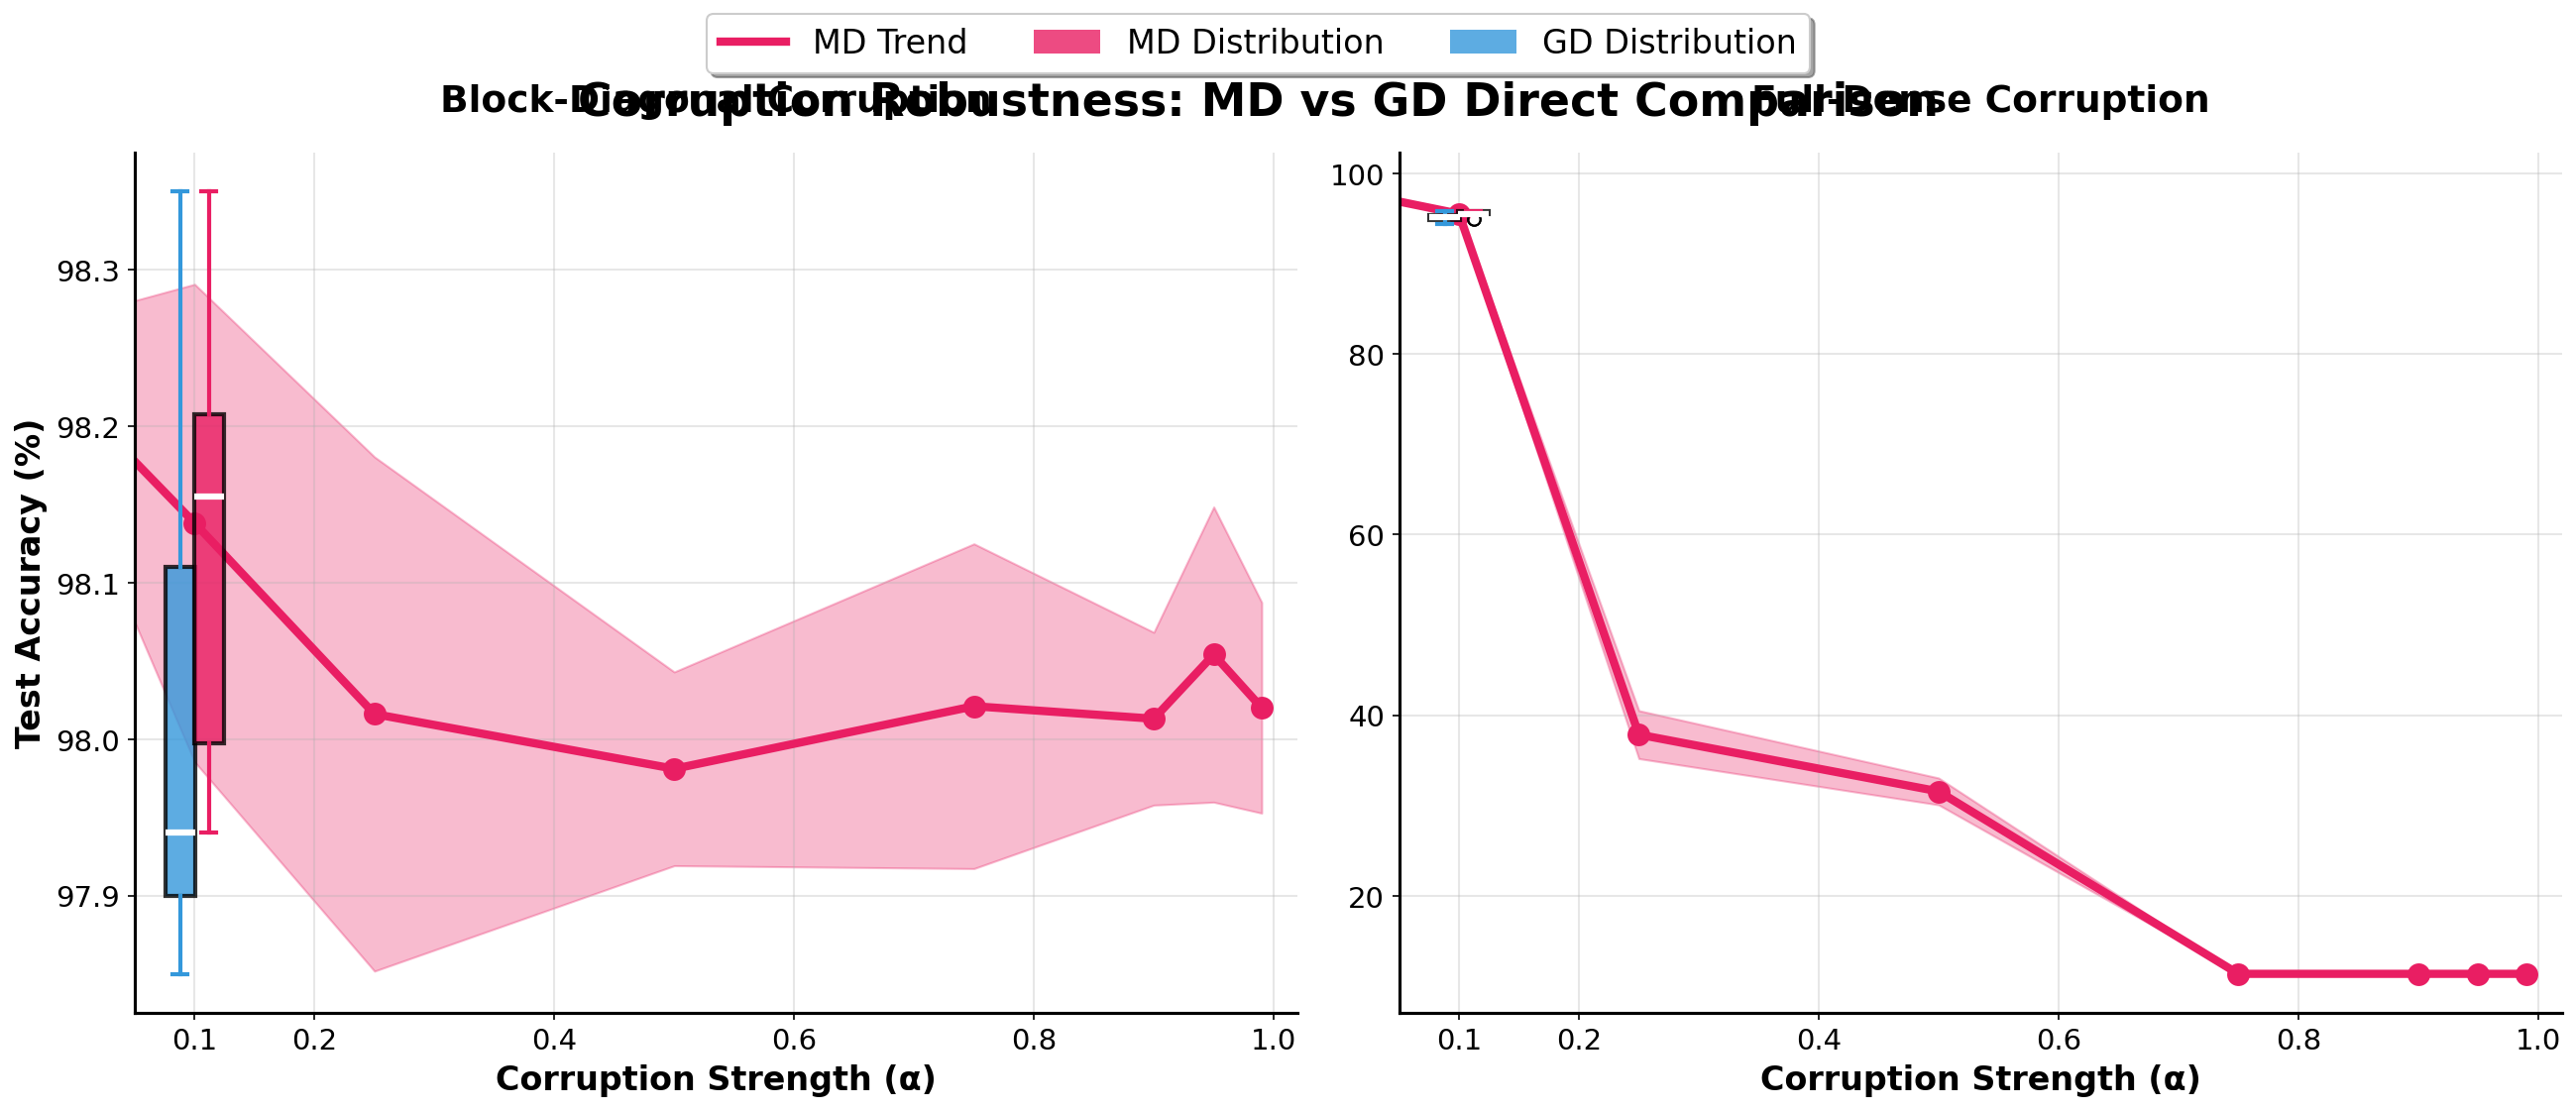

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Remove right y-axis label for second subplot
ax2.set_ylabel('')

for i, (corr_type, ax, title) in enumerate([
    ('block_diagonal', ax1, 'Block-Diagonal Corruption'),
    ('full_dense', ax2, 'Full-Dense Corruption')
]):
    # MD curves using TOP-10 runs only
    md_data = viz_data[(viz_data['optimizer_type'] == 'md') & 
                       (viz_data['corruption_type'] == corr_type)]
    if len(md_data) > 0:
        # Calculate confidence bands using top-10 runs per alpha
        md_curve_data = []
        max_accuracy = 0
        max_alpha = 0
        
        for alpha in sorted(md_data['alpha_corruption'].unique()):
            alpha_subset = md_data[md_data['alpha_corruption'] == alpha]
            top_10 = alpha_subset.nlargest(min(10, len(alpha_subset)), 'test_acc')
            
            mean_acc = top_10['test_acc'].mean() * 100
            std_acc = top_10['test_acc'].std() * 100
            
            md_curve_data.append({
                'alpha': alpha, 
                'mean': mean_acc, 
                'std': std_acc if not pd.isna(std_acc) else 0
            })
            
            # Track max for annotation (block-diagonal only)
            if corr_type == 'block_diagonal' and mean_acc > max_accuracy:
                max_accuracy = mean_acc
                max_alpha = alpha
        
        md_curve_df = pd.DataFrame(md_curve_data)
        
        # Plot MD trend line
        ax.plot(md_curve_df['alpha'], md_curve_df['mean'], 'o-', 
                color='#E91E63', linewidth=4, markersize=10, label='MD' if i == 0 else '')
        
        # Confidence band using top-10 std
        ax.fill_between(md_curve_df['alpha'], 
                       md_curve_df['mean'] - md_curve_df['std'],
                       md_curve_df['mean'] + md_curve_df['std'],
                       alpha=0.3, color='#E91E63')
        
        # Annotate maximum for block-diagonal corruption
        if corr_type == 'block_diagonal':
            ax.annotate(f'{max_accuracy:.1f}%', 
                       xy=(max_alpha, max_accuracy), 
                       xytext=(max_alpha + 0.05, max_accuracy + 5),
                       fontsize=16, fontweight='bold', color='#E91E63',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='white', 
                                edgecolor='#E91E63', linewidth=2),
                       arrowprops=dict(arrowstyle='->', color='#E91E63', lw=2))
    
    # Box plots using TOP-10 runs only
    gd_data = viz_data[(viz_data['optimizer_type'] == 'gd') & 
                       (viz_data['corruption_type'] == corr_type)]
    
    if len(gd_data) > 0:
        alphas_with_gd = sorted(gd_data['alpha_corruption'].unique())
        
        for alpha in alphas_with_gd:
            # GD top-10 box plot
            gd_alpha_data = gd_data[gd_data['alpha_corruption'] == alpha]
            gd_top10 = gd_alpha_data.nlargest(min(10, len(gd_alpha_data)), 'test_acc')['test_acc'].values * 100
            
            bp_gd = ax.boxplot([gd_top10], positions=[alpha - 0.012], widths=0.025,
                             patch_artist=True, 
                             boxprops=dict(facecolor='#3498DB', alpha=0.8, linewidth=2),
                             whiskerprops=dict(color='#3498DB', linewidth=2),
                             capprops=dict(color='#3498DB', linewidth=2),
                             medianprops=dict(color='white', linewidth=3))
            
            # MD top-10 box plot at same alpha
            md_alpha_data = md_data[md_data['alpha_corruption'] == alpha]
            if len(md_alpha_data) > 0:
                md_top10 = md_alpha_data.nlargest(min(10, len(md_alpha_data)), 'test_acc')['test_acc'].values * 100
                bp_md = ax.boxplot([md_top10], positions=[alpha + 0.012], widths=0.025,
                                 patch_artist=True,
                                 boxprops=dict(facecolor='#E91E63', alpha=0.8, linewidth=2),
                                 whiskerprops=dict(color='#E91E63', linewidth=2),
                                 capprops=dict(color='#E91E63', linewidth=2),
                                 medianprops=dict(color='white', linewidth=3))
    
    # Clean formatting with more space on left
    ax.set_title(title, fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Corruption Strength (α)', fontsize=16, fontweight='bold')
    if i == 0:
        ax.set_ylabel('Test Accuracy (%)', fontsize=16, fontweight='bold')
    
    # Fix x-axis with more left margin
    ax.set_xlim(0.05, 1.02)  # Start earlier to prevent cutoff
    
    # Clean x-axis ticks
    x_ticks = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([f'{x:.1f}' for x in x_ticks], fontsize=14)
    
    # Larger tick labels
    ax.tick_params(labelsize=14)
    ax.grid(True, alpha=0.3, linewidth=1)
    
    # Thicker spines
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

# Single shared legend
from matplotlib.patches import Patch
legend_elements = [
    plt.Line2D([0], [0], color='#E91E63', linewidth=4, label='MD Trend'),
    Patch(facecolor='#E91E63', alpha=0.8, label='MD Distribution'),
    Patch(facecolor='#3498DB', alpha=0.8, label='GD Distribution')
]

fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.95), 
          ncol=3, fontsize=16, frameon=True, fancybox=True, shadow=True)

plt.suptitle('Corruption Robustness: MD vs GD Direct Comparison', 
             fontsize=22, fontweight='bold', y=0.88)

# Adjust layout with more left margin
plt.tight_layout()
plt.subplots_adjust(top=0.82, left=0.08)  # More left margin

plt.show()

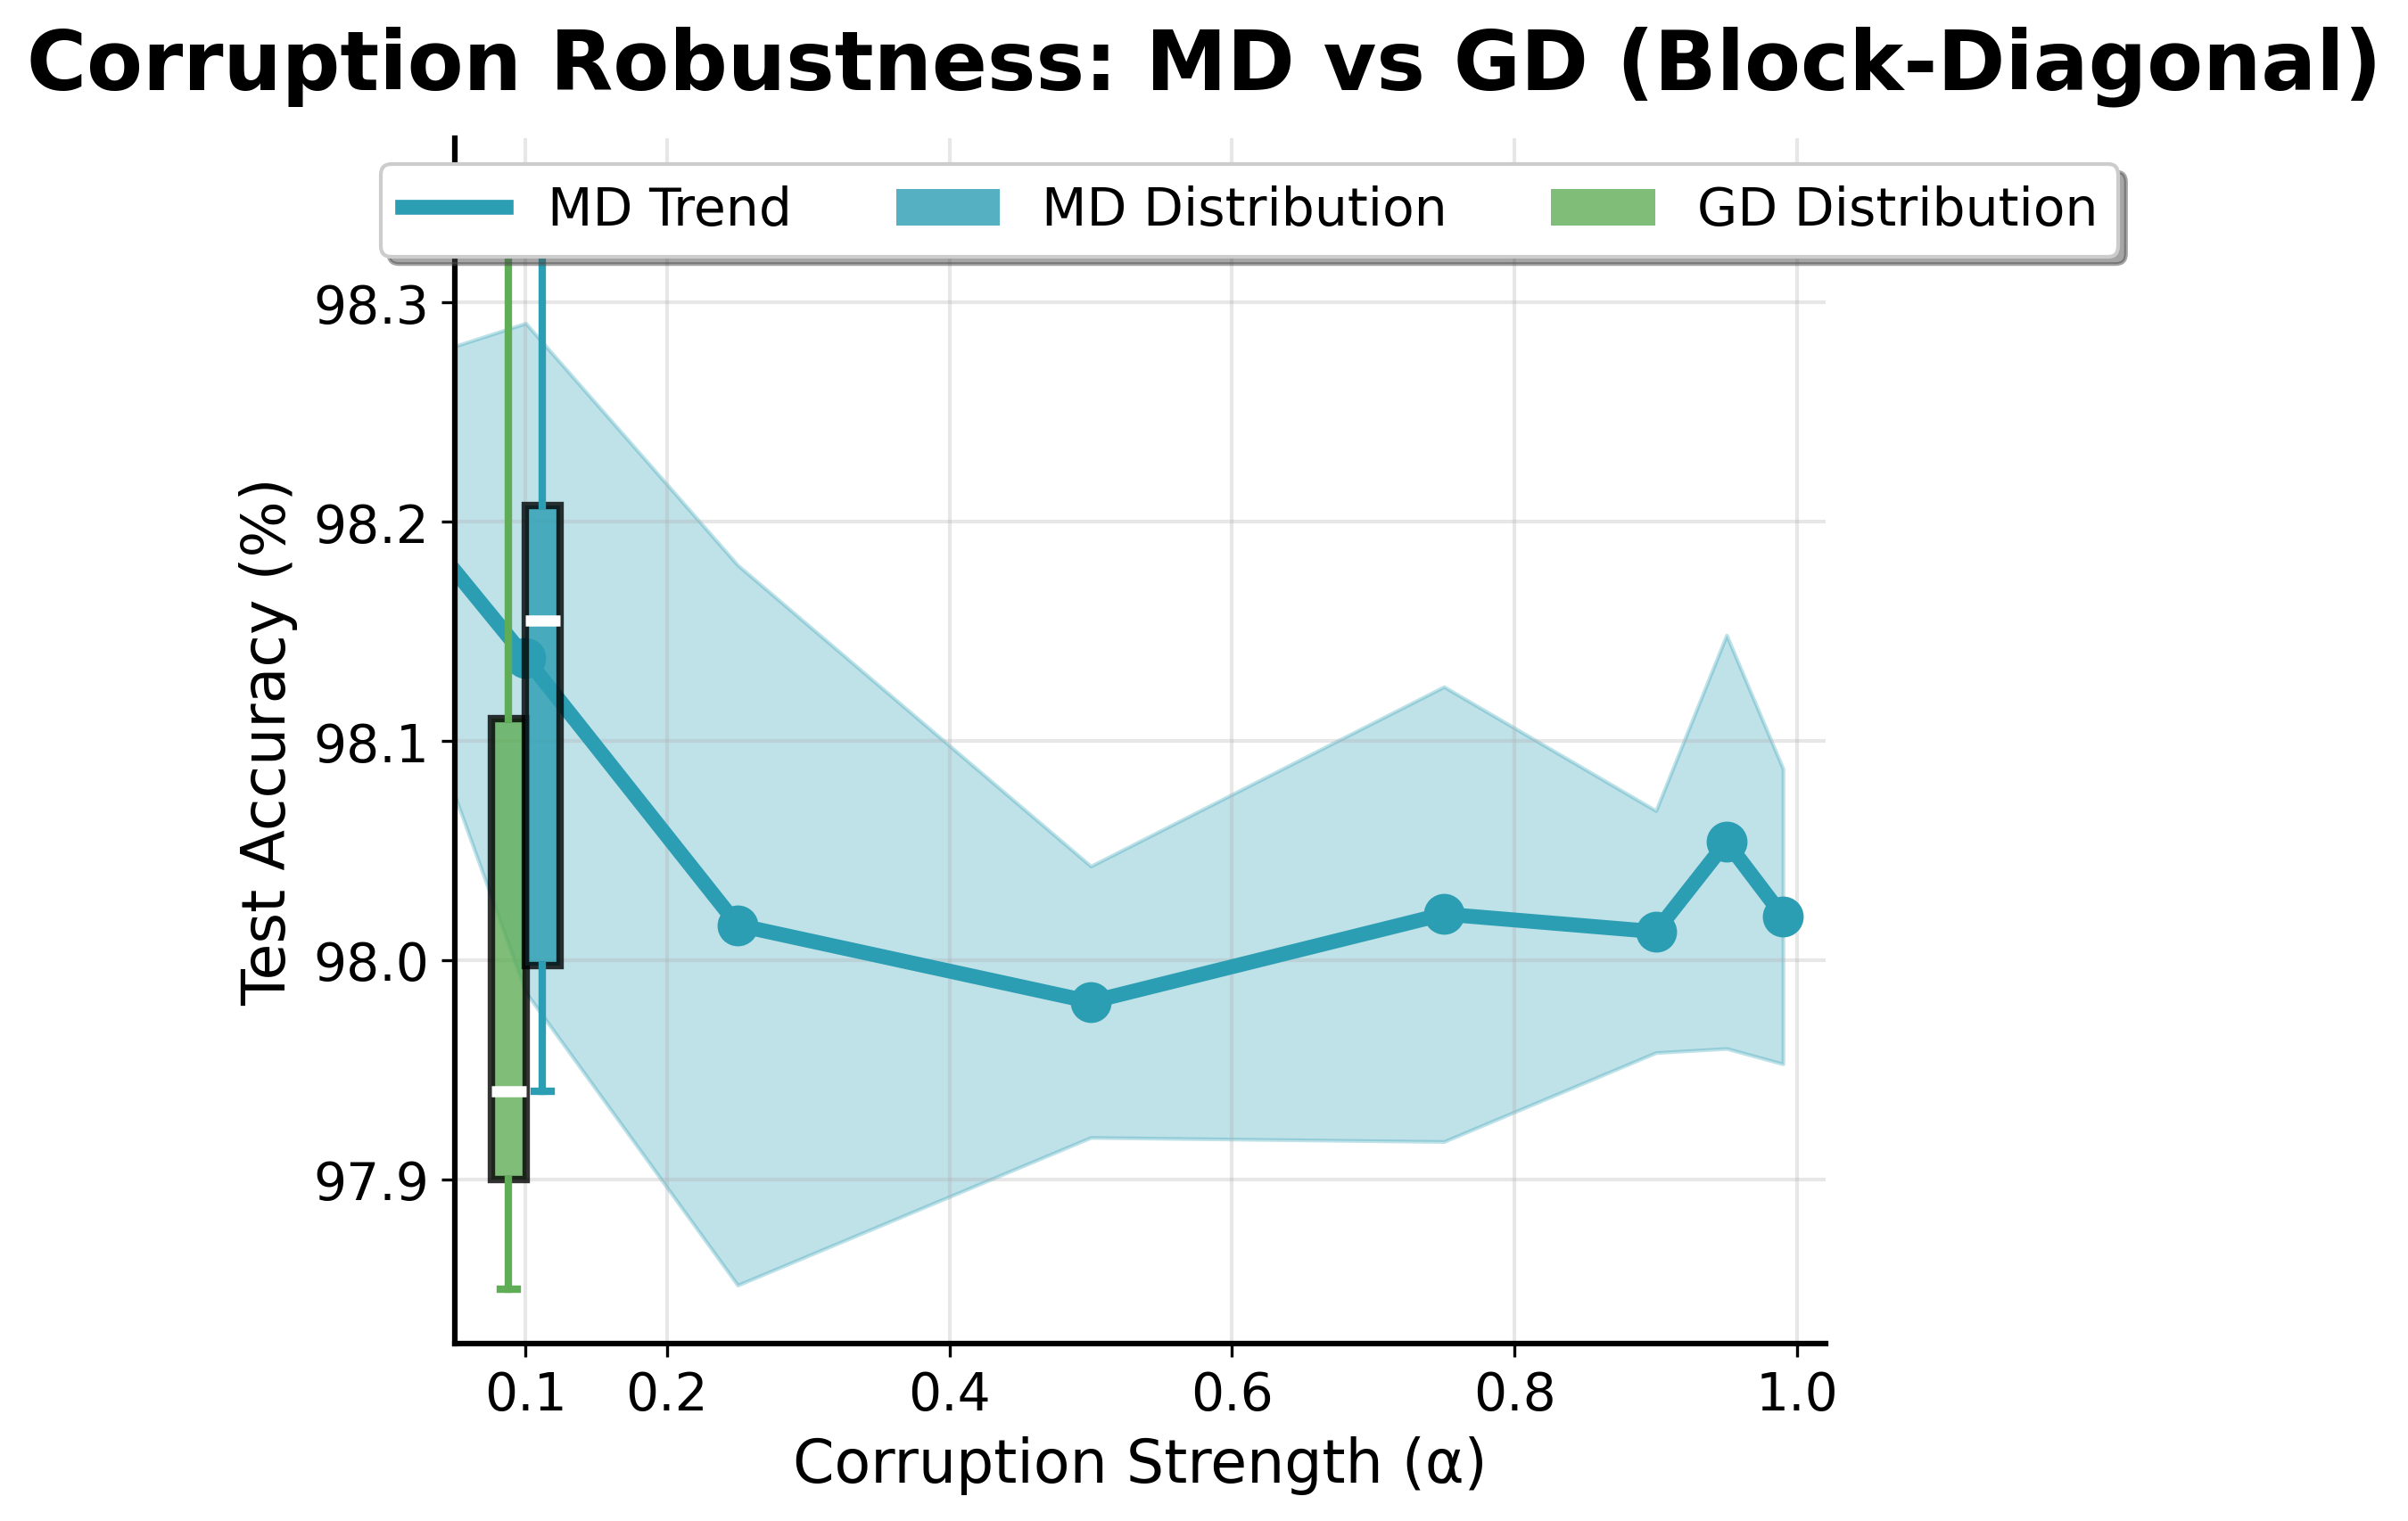

In [120]:
# Custom color palette
colors = {
    'SGD':     '#5fad56',
    'MD':      '#2b9eb3',
    'SGD+Mom': '#0b6e4f',
    'MD+Mom':  '#084c61'
}

fig, ax = plt.subplots(figsize=(7, 6), dpi=300)  # single panel

corr_type = 'block_diagonal'

# --- MD curves using TOP-10 runs only ---
md_data = viz_data[(viz_data['optimizer_type'] == 'md') & 
                   (viz_data['corruption_type'] == corr_type)]
if len(md_data) > 0:
    md_curve_data, max_accuracy, max_alpha = [], 0, 0
    for alpha in sorted(md_data['alpha_corruption'].unique()):
        alpha_subset = md_data[md_data['alpha_corruption'] == alpha]
        top_10 = alpha_subset.nlargest(min(10, len(alpha_subset)), 'test_acc')
        mean_acc = top_10['test_acc'].mean() * 100
        std_acc  = top_10['test_acc'].std()  * 100
        md_curve_data.append({'alpha': alpha, 'mean': mean_acc, 'std': std_acc or 0})
        if mean_acc > max_accuracy:
            max_accuracy, max_alpha = mean_acc, alpha

    md_curve_df = pd.DataFrame(md_curve_data)
    ax.plot(md_curve_df['alpha'], md_curve_df['mean'], 'o-', 
            color=colors['MD'], linewidth=4, markersize=10, label='MD')
    ax.fill_between(md_curve_df['alpha'], 
                   md_curve_df['mean'] - md_curve_df['std'],
                   md_curve_df['mean'] + md_curve_df['std'],
                   alpha=0.3, color=colors['MD'])
    ax.annotate(f'{max_accuracy:.1f}%', 
               xy=(max_alpha, max_accuracy), 
               xytext=(max_alpha + 0.05, max_accuracy + 5),
               fontsize=16, fontweight='bold', color=colors['MD'],
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', 
                        edgecolor=colors['MD'], linewidth=2),
               arrowprops=dict(arrowstyle='->', color=colors['MD'], lw=2))

# --- GD vs MD distributions ---
gd_data = viz_data[(viz_data['optimizer_type'] == 'gd') & 
                   (viz_data['corruption_type'] == corr_type)]
if len(gd_data) > 0:
    alphas_with_gd = sorted(gd_data['alpha_corruption'].unique())
    for alpha in alphas_with_gd:
        gd_alpha_data = gd_data[gd_data['alpha_corruption'] == alpha]
        gd_top10 = gd_alpha_data.nlargest(min(10, len(gd_alpha_data)), 'test_acc')['test_acc'].values * 100
        ax.boxplot([gd_top10], positions=[alpha - 0.012], widths=0.025,
                   patch_artist=True, 
                   boxprops=dict(facecolor=colors['SGD'], alpha=0.8, linewidth=2),
                   whiskerprops=dict(color=colors['SGD'], linewidth=2),
                   capprops=dict(color=colors['SGD'], linewidth=2),
                   medianprops=dict(color='white', linewidth=3))
        md_alpha_data = md_data[md_data['alpha_corruption'] == alpha]
        if len(md_alpha_data) > 0:
            md_top10 = md_alpha_data.nlargest(min(10, len(md_alpha_data)), 'test_acc')['test_acc'].values * 100
            ax.boxplot([md_top10], positions=[alpha + 0.012], widths=0.025,
                       patch_artist=True,
                       boxprops=dict(facecolor=colors['MD'], alpha=0.8, linewidth=2),
                       whiskerprops=dict(color=colors['MD'], linewidth=2),
                       capprops=dict(color=colors['MD'], linewidth=2),
                       medianprops=dict(color='white', linewidth=3))

# --- Formatting ---
# ax.set_title(title, fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Corruption Strength (α)', fontsize=16)
ax.set_ylabel('Test Accuracy (%)', fontsize=16)
ax.set_xlim(0.05, 1.02)
ax.set_xticks([0.1, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticklabels([f'{x:.1f}' for x in [0.1,0.2,0.4,0.6,0.8,1.0]], fontsize=14)
ax.tick_params(labelsize=14)
ax.grid(True, alpha=0.3, linewidth=1)
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

# --- Legend & title ---
from matplotlib.patches import Patch
legend_elements = [
    plt.Line2D([0], [0], color=colors['MD'], linewidth=4, label='MD Trend'),
    Patch(facecolor=colors['MD'], alpha=0.8, label='MD Distribution'),
    Patch(facecolor=colors['SGD'], alpha=0.8, label='GD Distribution')
]
ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.58, 1.0),
          ncol=3, fontsize=14, frameon=True, fancybox=True, shadow=True)

plt.suptitle('Corruption Robustness: MD vs GD (Block-Diagonal)', 
             fontsize=22, fontweight='bold', y=0.95)
plt.tight_layout()
plt.subplots_adjust(top=0.88, left=0.1)
plt.show()

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_md_heatmaps_by_corruption_strength_viz(
    viz_data: pd.DataFrame,
    corruption_type: str = "block_diagonal",
    topk: int = 10,
    max_panels: int = 8,      # you have 8 strengths: 0.01..0.99
    cmap: str = "magma"
):
    d = viz_data.copy()

    # Filter MD + selected corruption type
    d = d[d["optimizer_type"].astype(str).str.lower().eq("md")]
    d = d[d["corruption_type"].astype(str).str.lower().eq(corruption_type)]
    if d.empty:
        print(f"[warn] No MD rows for corruption_type='{corruption_type}'"); return

    # Keep necessary cols
    need = ["alpha_learning", "block_size", "alpha_corruption", "test_acc"]
    d = d.dropna(subset=need).copy()
    if d.empty:
        print("[warn] After dropping NaNs, nothing to plot."); return

    # Scale test_acc to % exactly once
    m = d["test_acc"].mean()
    d["acc_pct"] = d["test_acc"]*100.0 if (pd.notna(m) and m <= 1.5) else d["test_acc"].astype(float)

    # Axes domains
    alphas   = sorted(pd.unique(d["alpha_learning"].astype(float)))
    blocks   = sorted(pd.unique(d["block_size"].astype(int)))
    strengths_all = sorted(pd.unique(d["alpha_corruption"].astype(float)))

    if not alphas or not blocks or not strengths_all:
        print("[warn] Missing alpha/block/strength values."); return

    # Choose strengths (limit panels for poster)
    if len(strengths_all) > max_panels:
        qs = np.linspace(0, 1, max_panels)
        strengths = sorted({float(np.quantile(strengths_all, q)) for q in qs})
    else:
        strengths = strengths_all

    # Build grids and gather values for global color scale
    panels, finite_vals = [], []
    for s in strengths:
        sub = d[np.isclose(d["alpha_corruption"].astype(float), s)]
        grid = np.full((len(blocks), len(alphas)), np.nan)
        if not sub.empty:
            for i, b in enumerate(blocks):
                sb = sub[sub["block_size"].astype(int) == b]
                for j, a in enumerate(alphas):
                    cell = sb[np.isclose(sb["alpha_learning"].astype(float), a)]["acc_pct"]
                    if len(cell):
                        top = cell.sort_values(ascending=False).head(min(topk, len(cell)))
                        if len(top):
                            grid[i, j] = float(top.mean())
        panels.append((s, grid))
        finite_vals.extend(grid[np.isfinite(grid)].ravel().tolist())

    if not finite_vals:
        print("[warn] All panels empty."); return
    vmin, vmax = float(np.min(finite_vals)), float(np.max(finite_vals))

    # Plot small multiples
    n = len(strengths)
    fig, axes = plt.subplots(1, n, figsize=(4.4*n, 4.4), squeeze=False)
    axes = axes[0]
    last_im = None

    for ax, (s, grid) in zip(axes, panels):
        if np.isfinite(grid).any():
            im = ax.imshow(grid, aspect="auto", vmin=vmin, vmax=vmax, cmap=cmap)
            last_im = im
            # annotate best cell
            r, c = np.unravel_index(np.nanargmax(grid), grid.shape)
            best = grid[r, c]
            ax.scatter(c, r, s=55)
            ax.text(c, r, f"{best:.1f}", ha="center", va="center", fontsize=10, fontweight="bold")
        else:
            ax.text(0.5, 0.5, "(no data)", ha="center", va="center", fontsize=11)
        ax.set_title(f"α_corruption = {s:.2f}", fontweight="bold", pad=10)
        ax.set_xticks(range(len(alphas))); ax.set_xticklabels([str(a) for a in alphas], rotation=45, ha="right")
        ax.set_yticks(range(len(blocks))); ax.set_yticklabels([str(b) for b in blocks])
        ax.set_xlabel("MD α")
        if ax is axes[0]:
            ax.set_ylabel("block size")

    if last_im is not None:
        cbar = fig.colorbar(last_im, ax=axes.ravel().tolist(), fraction=0.025, pad=0.04)
        cbar.set_label("Test Accuracy (%)")

    fig.suptitle(
        f"MD Only — Corruption Robustness ({corruption_type.replace('_','-')})\n"
        f"Cells = Top-{topk} mean per (MD α, block size)",
        y=0.98, fontsize=14, fontweight="bold"
    )
    fig.tight_layout(rect=[0, 0, 1, 0.94])
    return fig#


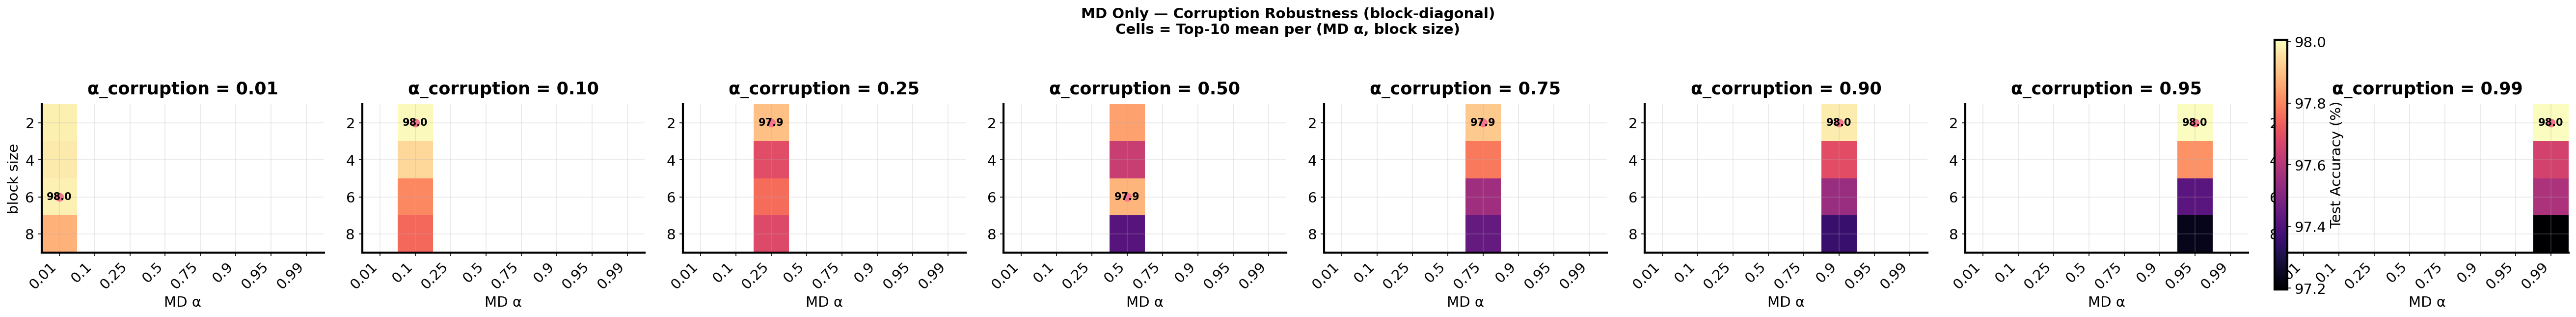

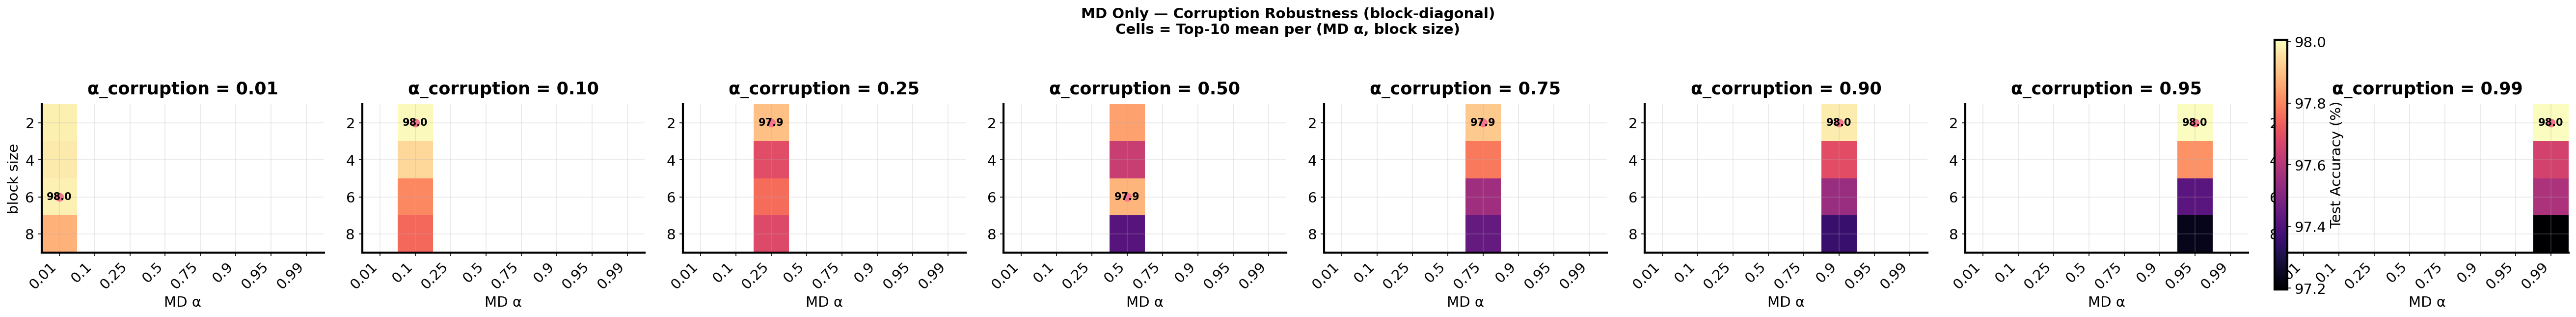

In [81]:
# Block-diagonal (main story)
plot_md_heatmaps_by_corruption_strength_viz(
    viz_data, corruption_type="block_diagonal", topk=10, max_panels=8, cmap="magma"
)

# Full-dense (optional contrast)
# plot_md_heatmaps_by_corruption_strength_viz(viz_data, corruption_type="full_dense", topk=10)

In [79]:
def plot_md_3d_heatmap(viz_data, corruption_type="block_diagonal", topk=10, cmap="magma"):
    d = viz_data.copy()
    d = d[d["optimizer_type"].astype(str).str.lower().eq("md")]
    d = d[d["corruption_type"].astype(str).str.lower().eq(corruption_type)]

    if d.empty:
        print(f"[warn] No MD data for corruption_type='{corruption_type}'")
        return

    d = d.dropna(subset=["alpha_learning", "block_size", "alpha_corruption", "test_acc"]).copy()
    if d.empty:
        print("[warn] After dropna, nothing left."); return

    # scale to %
    mean_metric = d["test_acc"].mean()
    d["acc_pct"] = d["test_acc"]*100 if mean_metric <= 1.5 else d["test_acc"]

    alphas   = sorted(d["alpha_learning"].unique())
    strengths= sorted(d["alpha_corruption"].unique())
    blocks   = sorted(d["block_size"].unique())

    # --- make one panel per block size ---
    n = len(blocks)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5), squeeze=False)
    axes = axes[0]

    for ax, b in zip(axes, blocks):
        sub = d[d["block_size"] == b]
        grid = np.full((len(strengths), len(alphas)), np.nan)
        for i, s in enumerate(strengths):
            for j, a in enumerate(alphas):
                cell = sub[(sub["alpha_corruption"] == s) & (sub["alpha_learning"] == a)]["acc_pct"]
                top = cell.sort_values(ascending=False).head(min(topk, len(cell)))
                if len(top): grid[i,j] = top.mean()

        im = ax.imshow(grid, origin="lower", aspect="auto", cmap=cmap,
                       extent=[min(alphas), max(alphas), min(strengths), max(strengths)])
        ax.set_title(f"Block size = {b}", fontweight="bold")
        ax.set_xlabel("MD α")
        ax.set_ylabel("Corruption strength (α_c)")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Test Accuracy (%)")

    fig.suptitle(f"MD Only — Corruption Robustness ({corruption_type.replace('_','-')})\n"
                 f"Top-{topk} mean per (MD α, corruption strength), split by block size",
                 fontsize=14, fontweight="bold", y=0.97)
    plt.tight_layout(rect=[0,0,1,0.94])
    return fig

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_md_equal_alpha_heatmap(
    viz_data: pd.DataFrame,
    corruption_type: str = "block_diagonal",
    topk: int = 10,
    cmap: str = "magma",
    annotate_best: bool = True,
):
    d = viz_data.copy()

    # MD + chosen corruption type
    d = d[d["optimizer_type"].astype(str).str.lower().eq("md")]
    d = d[d["corruption_type"].astype(str).str.lower().eq(corruption_type)]

    # needed columns
    need = ["alpha_learning", "alpha_corruption", "block_size", "test_acc"]
    d = d.dropna(subset=need).copy()
    if d.empty:
        print(f"[warn] no rows after filtering for MD & {corruption_type}")
        return

    # scale to percent once
    mean_acc = d["test_acc"].mean()
    d["acc_pct"] = d["test_acc"]*100.0 if (pd.notna(mean_acc) and mean_acc <= 1.5) else d["test_acc"].astype(float)

    # enforce α_MD == α_corruption (with tolerance)
    d = d[np.isclose(d["alpha_learning"].astype(float), d["alpha_corruption"].astype(float))].copy()
    if d.empty:
        print("[warn] no rows with alpha_learning == alpha_corruption")
        return

    # grid axes
    alphas = sorted(pd.unique(d["alpha_learning"].astype(float)))
    blocks = sorted(pd.unique(d["block_size"].astype(int)))

    # build grid: rows=block_size, cols=alpha (equal to corruption α)
    grid = np.full((len(blocks), len(alphas)), np.nan)
    for i, b in enumerate(blocks):
        sb = d[d["block_size"].astype(int) == b]
        for j, a in enumerate(alphas):
            cell = sb[np.isclose(sb["alpha_learning"].astype(float), a)]["acc_pct"]
            if len(cell):
                top = cell.sort_values(ascending=False).head(min(topk, len(cell)))
                if len(top):
                    grid[i, j] = float(top.mean())

    if not np.isfinite(grid).any():
        print("[warn] all cells empty")
        return

    vmin, vmax = np.nanmin(grid), np.nanmax(grid)

    # plot single heatmap
    fig, ax = plt.subplots(figsize=(8.5, 4.8))
    im = ax.imshow(grid, aspect="auto", vmin=vmin, vmax=vmax, cmap=cmap)

    # ticks/labels
    ax.set_xticks(range(len(alphas)))
    ax.set_xticklabels([str(a) for a in alphas], rotation=45, ha="right")
    ax.set_yticks(range(len(blocks)))
    ax.set_yticklabels([str(b) for b in blocks])
    ax.set_xlabel("α (MD = corruption)")
    ax.set_ylabel("block size")
    ax.set_title(f"MD Only — Corruption Robustness ({corruption_type.replace('_','-')})\n"
                 f"Cells: Top-{topk} mean test accuracy", fontweight="bold", pad=10)

    # annotate global best cell
    if annotate_best and np.isfinite(grid).any():
        r, c = np.unravel_index(np.nanargmax(grid), grid.shape)
        best = grid[r, c]
        ax.scatter(c, r, s=60, edgecolor="white", facecolor="none", linewidth=2)
        ax.text(c, r, f"{best:.1f}", ha="center", va="center",
                fontsize=10, fontweight="bold", color="white")

    # colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.035, pad=0.04)
    cbar.set_label("Test Accuracy (%)")

    fig.tight_layout()
    return fig

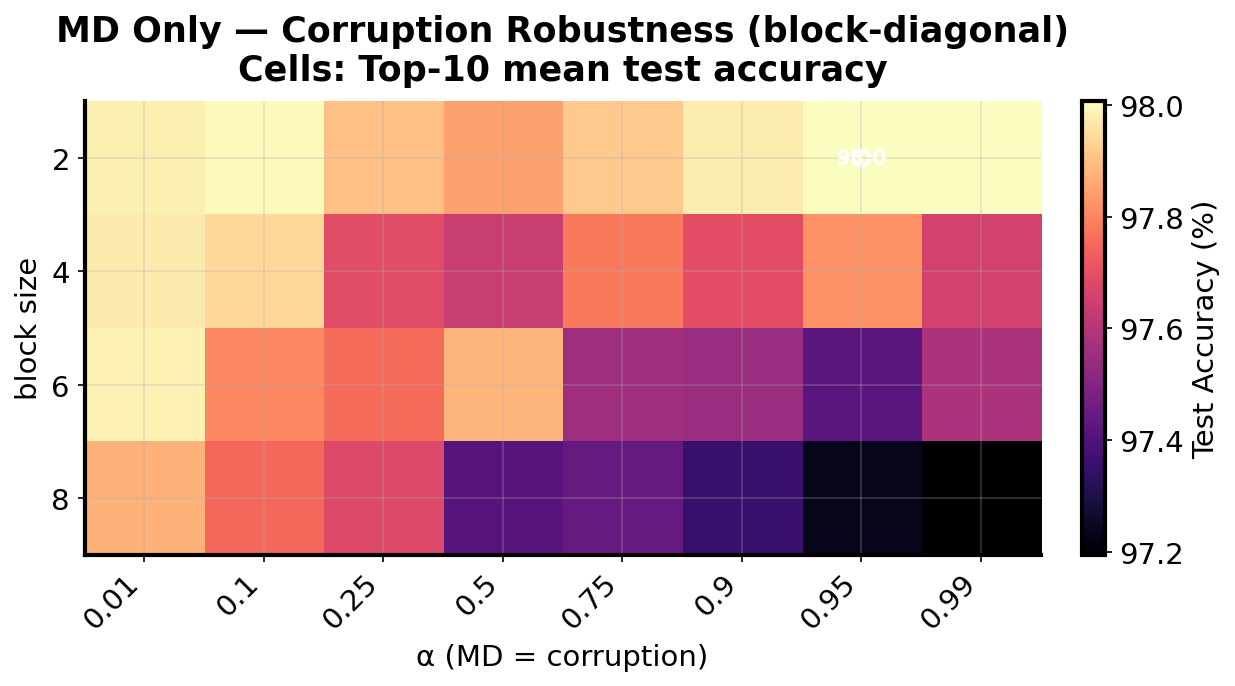

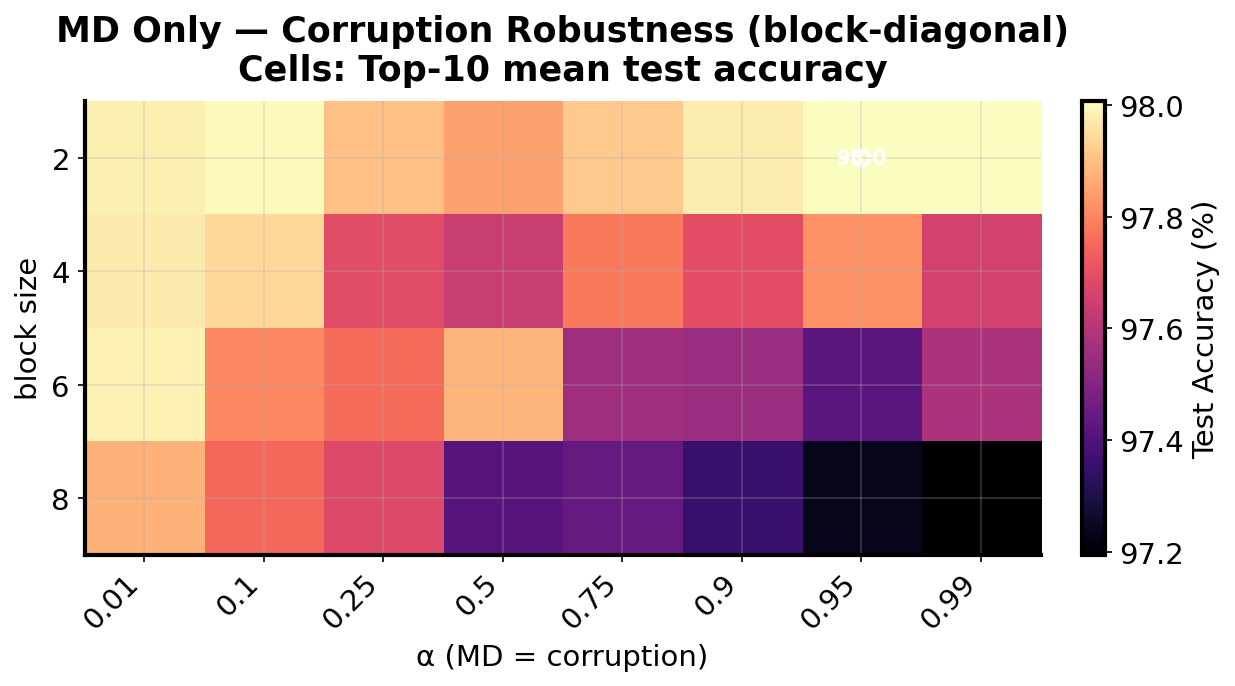

In [83]:
# Single, compact figure (your main story)
plot_md_equal_alpha_heatmap(viz_data, corruption_type="block_diagonal", topk=10, cmap="magma")
# (optional) contrast
# plot_md_equal_alpha_heatmap(viz_data, corruption_type="full_dense", topk=10)

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# define custom green–blue colormap
colors = {
    'SGD':     '#5fad56',  # main green
    'MD':      '#2b9eb3',  # main blue
    'SGD+Mom': '#0b6e4f',
    'MD+Mom':  "#116f8b"
}

# create a lighter green by mixing with white (~70% white, 30% original green)
lighter_green = "#a8d5a0"   # precomputed lighter tone of #5fad56

# custom colormap: lighter green → MD blue
greenblue_cmap = LinearSegmentedColormap.from_list(
    "greenblue_custom", [lighter_green, colors['MD+Mom']]
)

def plot_md_equal_alpha_heatmap_rotated(
    viz_data: pd.DataFrame,
    corruption_type: str = "block_diagonal",
    topk: int = 10,
    cmap=greenblue_cmap,   # default = greenblue
):
    d = viz_data.copy()
    d = d[d["optimizer_type"].astype(str).str.lower().eq("md")]
    d = d[d["corruption_type"].astype(str).str.lower().eq(corruption_type)]
    d = d.dropna(subset=["alpha_learning", "alpha_corruption", "block_size", "test_acc"]).copy()

    # scale accuracy to %
    mean_acc = d["test_acc"].mean()
    d["acc_pct"] = d["test_acc"]*100.0 if (pd.notna(mean_acc) and mean_acc <= 1.5) else d["test_acc"].astype(float)

    # enforce α_MD == α_corruption
    d = d[np.isclose(d["alpha_learning"].astype(float), d["alpha_corruption"].astype(float))]
    if d.empty:
        print("[warn] no rows with α_MD == α_corruption for", corruption_type)
        return

    alphas = sorted(pd.unique(d["alpha_learning"].astype(float)))       # y-axis
    blocks = sorted(pd.unique(d["block_size"].astype(int)))             # x-axis

    # build grid: rows=block_size, cols=alpha  (then transpose for rotation)
    grid = np.full((len(blocks), len(alphas)), np.nan, dtype=float)
    for i, b in enumerate(blocks):
        sb = d[d["block_size"].astype(int) == b]
        for j, a in enumerate(alphas):
            cell = sb[np.isclose(sb["alpha_learning"].astype(float), a)]["acc_pct"]
            if len(cell):
                top = cell.sort_values(ascending=False).head(min(topk, len(cell)))
                if len(top):
                    grid[i, j] = float(top.mean())

    if not np.isfinite(grid).any():
        print("[warn] all cells empty"); return

    # rotate 90°: x <- blocks, y <- alphas
    grid_rot = grid.T
    vmin, vmax = np.nanmin(grid_rot), np.nanmax(grid_rot)

    fig, ax = plt.subplots(figsize=(4.5, 6), dpi=400)
    im = ax.imshow(
        grid_rot,
        aspect="auto",
        cmap=cmap,
        vmin=vmin, vmax=vmax,
        interpolation="nearest"
    )

    # ticks/labels with bigger fonts
    ax.set_xticks(range(len(blocks)))
    ax.set_xticklabels([str(b) for b in blocks], fontsize=14)
    ax.set_yticks(range(len(alphas)))
    ax.set_yticklabels([f"{a:.2f}" for a in alphas], fontsize=14)

    ax.set_xlabel("Block size", fontsize=16)
    ax.set_ylabel("α: corruption strength/weight competition", fontsize=16)
    # ax.set_title(
    #     f"Corruption Robustness ({corruption_type.replace('_','-')}) for MD",
    #     fontsize=18, pad=14
    # )

    # annotate best cell
    r, c = np.unravel_index(np.nanargmax(grid_rot), grid_rot.shape)
    best = grid_rot[r, c]
    ax.text(c, r, f"{best:.2f}", ha="center", va="center",
            fontsize=12, color="white")

    # colorbar on right
    cbar = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.05, pad=0.03)
    cbar.set_label("Test Accuracy (%)", fontsize=16)
    cbar.ax.tick_params(labelsize=12)

    fig.tight_layout()
    return fig

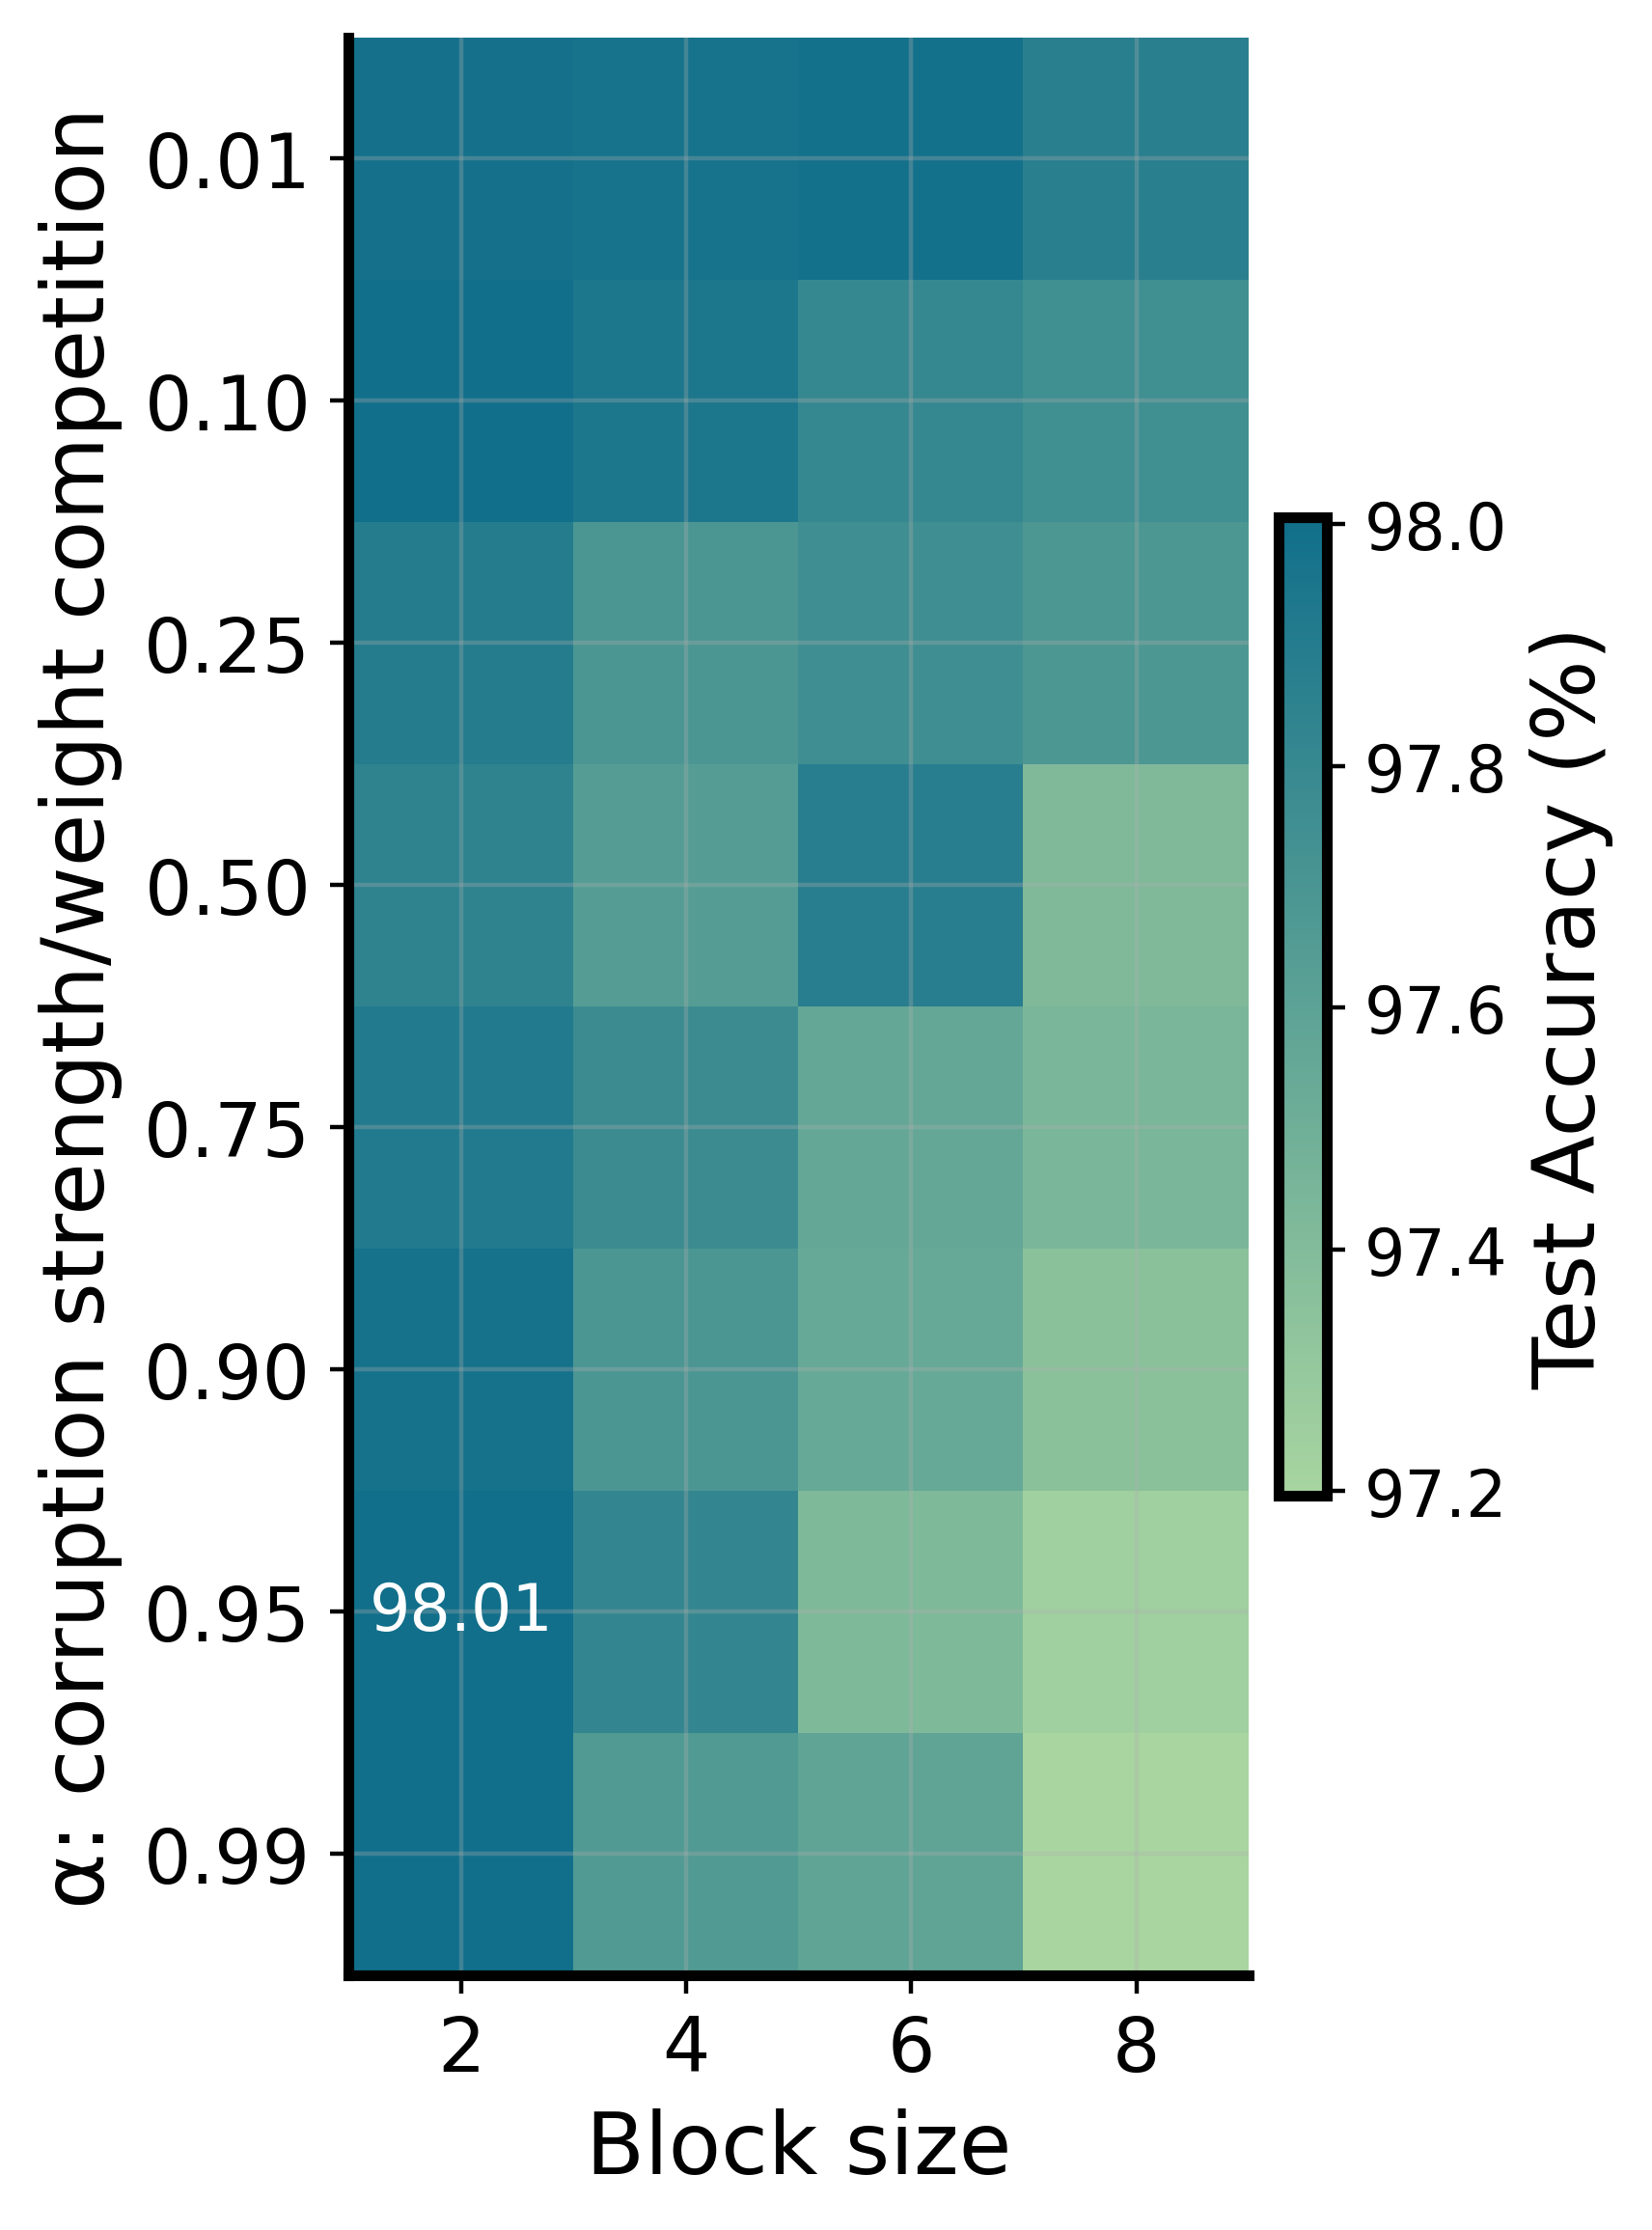

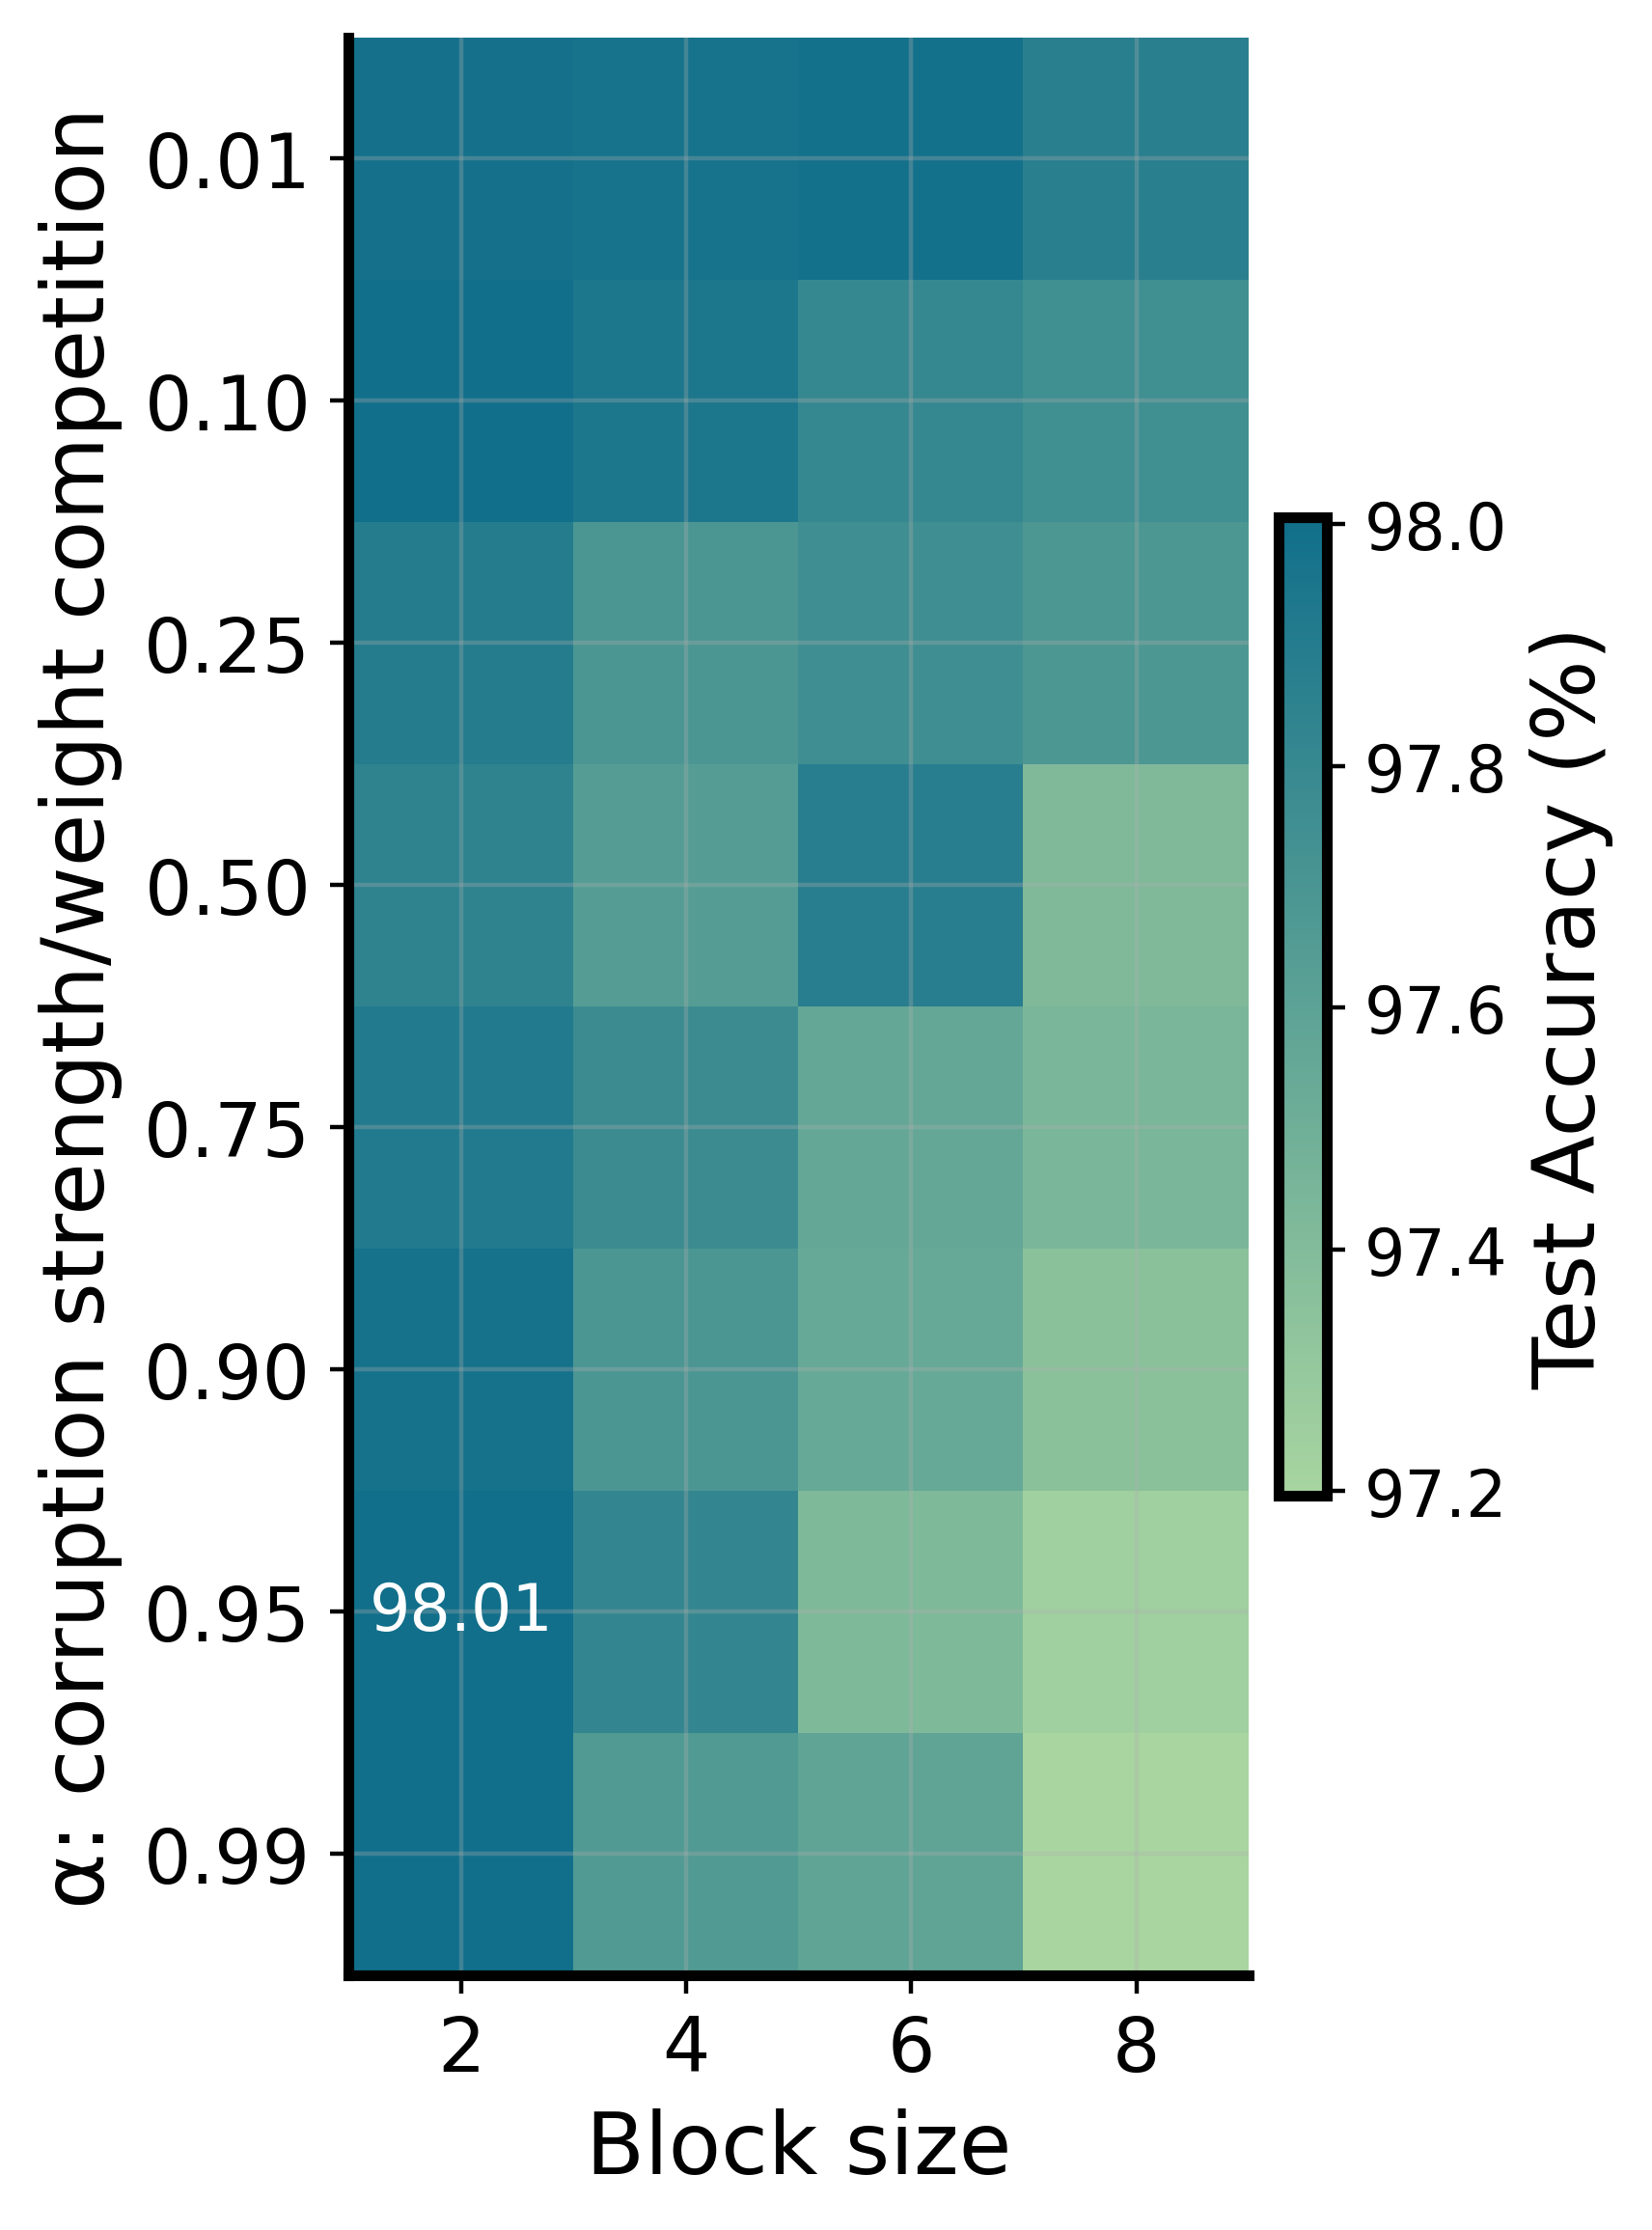

In [131]:
plot_md_equal_alpha_heatmap_rotated(viz_data)